## Imports

In [1]:
import io
import pathlib
import pickle
import re
import pandas as pd
pd.set_option('display.max_rows', None)

import ads
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy.stats import median_absolute_deviation as MAD
from gala.units import galactic
from helpers import (
    get_default_track_for_stream,
    get_frame_from_points,
    get_full_galstreams_poly,
    get_isochrone,
    make_ibata_poly_nodes,
    run_orbit_fit,
)
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

from astropy.table import Table, Column, vstack, hstack, join, unique

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3
Gaia.ROW_LIMIT = -1

import os

%matplotlib inline

## Stream census

In [2]:
mwstreams = galstreams.MWStreams(implement_Off=True)

Initializing galstreams library from master_log... 


In [3]:
mwstreams

{'20.0-1-M18': <galstreams.core.Track6D at 0x7f125c1087c0>,
 '300S-F18': <galstreams.core.Track6D at 0x7f125d993190>,
 'AAU-ATLAS-L21': <galstreams.core.Track6D at 0x7f1202998ac0>,
 'AAU-AliqaUma-L21': <galstreams.core.Track6D at 0x7f1202906a00>,
 'ACS-R21': <galstreams.core.Track6D at 0x7f125c108b80>,
 'ATLAS-I21': <galstreams.core.Track6D at 0x7f1202882670>,
 'ATLAS-I24': <galstreams.core.Track6D at 0x7f120299eca0>,
 'Acheron-G09': <galstreams.core.Track6D at 0x7f12029bb310>,
 'Alpheus-G13': <galstreams.core.Track6D at 0x7f12029982e0>,
 'Aquarius-W11': <galstreams.core.Track6D at 0x7f120295bb80>,
 'C-10-I24': <galstreams.core.Track6D at 0x7f12029730d0>,
 'C-11-I24': <galstreams.core.Track6D at 0x7f1202a0acd0>,
 'C-12-I24': <galstreams.core.Track6D at 0x7f120289e820>,
 'C-13-I24': <galstreams.core.Track6D at 0x7f1202948cd0>,
 'C-19-I21': <galstreams.core.Track6D at 0x7f12029bb4c0>,
 'C-19-I24': <galstreams.core.Track6D at 0x7f120288de50>,
 'C-20-I24': <galstreams.core.Track6D at 0x7f1

In [4]:
gnames = list(mwstreams.keys())
print(len(gnames))

217


In [5]:
mwstreams.summary.columns

Index(['Imp', 'On', 'TrackName', 'Name', 'TrackRefs', 'TrackRefsLatex',
       'Notes', 'from-Members', 'width_phi2', 'width_phi2_Ref',
       'width_pm_phi1_cosphi2', 'width_pm_phi1_cosphi2_Ref', 'width_pm_phi2',
       'width_pm_phi2_Ref', 'total_v_sigma', 'total_v_sigma_Ref', 'Lv_stream',
       'L_Ref', 'width_comment', 'length', 'ra_o', 'dec_o', 'distance_o',
       'ra_f', 'dec_f', 'distance_f', 'ra_mid', 'dec_mid', 'distance_mid',
       'ra_pole', 'dec_pole', 'InfoFlags', 'has_empirical_track', 'has_D',
       'has_pm', 'has_vrad', 'DiscoveryRefs', 'ID'],
      dtype='object')

In [6]:
mwstreams.summary

,Imp,On,TrackName,Name,TrackRefs,TrackRefsLatex,Notes,from-Members,width_phi2,width_phi2_Ref,...,distance_mid,ra_pole,dec_pole,InfoFlags,has_empirical_track,has_D,has_pm,has_vrad,DiscoveryRefs,ID
TrackName,,,,,,,,,,,,,,,,,,,,,
20.0-1-M18,po,True,20.0-1-M18,20.0-1,mateu2018,Mateu2018,-,0,1.80,Riley2020,...,26.839948,235.758575,38.821881,0000,0,0,0,0,Mateu2018,1
300S-F18,st,True,300S-F18,300S,fu2018,Fu2018,-,0,0.40,Fu2018,...,15.929409,308.056470,72.509388,1101,1,1,0,1,"NiedersteOstholt2009,Simon2011",2
AAU-ATLAS-L21,st,True,AAU-ATLAS-L21,AAU-ATLAS,li2021,Li2021,-,1,0.30,Li2021,...,21.478244,74.259067,47.933124,1111,1,1,1,1,Koposov2014,3
AAU-AliqaUma-L21,st,True,AAU-AliqaUma-L21,AAU-AliqaUma,li2021,Li2021,-,1,0.26,Li2021,...,21.981943,74.259067,47.933124,1111,1,1,1,1,Shipp2018,4
ACS-R21,st,True,ACS-R21,ACS,ramos2021,Ramos2021,-,0,2.10,Riley2020,...,11.700000,212.301639,-4.733141,1110,1,1,1,0,Grillmair2006_acs,5
ATLAS-I21,st,False,ATLAS-I21,AAU-ATLAS,ibata2021,Ibata2021,-,1,0.35,from-Members,...,24.642130,80.544842,44.626077,1111,1,1,1,1,Koposov2014,
ATLAS-I24,st,False,ATLAS-I24,AAU-ATLAS,ibata2024,Ibata2024,-,1,0.41,from-Members,...,1.000000,76.343232,47.439685,1111,1,1,1,1,Koposov2014,
Acheron-G09,ep,True,Acheron-G09,Acheron,grillmair2009,Grillmair2009,-,0,0.40,Riley2020,...,3.656382,142.339428,49.453184,0000,0,0,0,0,Grillmair2009,8
Alpheus-G13,st,True,Alpheus-G13,Alpheus,grillmair2013,Grillmair2013,-,0,1.40,Riley2020,...,1.800264,301.571407,4.280719,1100,1,1,0,0,Grillmair2013,9


In [7]:
gnames = np.unique(mwstreams.summary['Name'])

In [8]:
gnames

array(['20.0-1', '300S', 'AAU-ATLAS', 'AAU-AliqaUma', 'ACS', 'Acheron',
       'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19',
       'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8',
       'C-9', 'Cetus', 'Cetus-New', 'Cetus-Palca', 'Cocytos', 'Corvus',
       'Elqui', 'Eridanus', 'Fimbulthul', 'GD-1', 'Gaia-1', 'Gaia-10',
       'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5',
       'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus',
       'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum', 'Jhelum-a',
       'Jhelum-b', 'Kshir', 'Kwando', 'LMS-1', 'Leiptr', 'Lethe', 'M2',
       'M3-Svol', 'M30', 'M5', 'M68', 'M68-Fjorm', 'M92', 'Molonglo',
       'Monoceros', 'Murrumbidgee', 'NGC1261', 'NGC1261a', 'NGC1261b',
       'NGC1851', 'NGC2298', 'NGC2808', 'NGC288', 'NGC3201',
       'NGC3201-Gjoll', 'NGC5053', 'NGC5466', 'NGC6101', 'NGC6362',
       'NGC6397', 'NGC7492', 'New-1', 'New-10', 'New-11', 'New-12',
       'New-13', 'N

In [9]:
names = ['20.0-1', '300S', 'ATLAS-Aliqa Uma', 'Acheron',
       'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19',
       'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8',
       'C-9', 'Cetus-Palca', 'Cocytos', 'Corvus',
       'Elqui', 'Eridanus', 'GD-1', 'Gaia-1', 
       'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5',
       'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus',
       'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum',
       'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'Lethe', 'M2',
       'M3', 'M30', 'M5', 'M68', 'M92', 'Molonglo',
       'Murrumbidgee', 'NGC 1261',
       'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201',
       'NGC 5053', 'NGC 5466', 'NGC 5824', 'NGC 6101', 'NGC 6362',
       'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12',
       'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18',
       'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23',
       'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5',
       'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri',
       'Ophiuchus', 'Orinoco', 'Orphan-Chenab', 'PS1-A', 'PS1-B', 'PS1-C',
       'PS1-D', 'PS1-E', 'Palomar 13', 'Palomar 15', 'Palomar 5',  'Parallel',
       'Pegasus', 'Perpendicular', 'Phlegethon', 'Phoenix', 'Ravi',
       'SGP-S', 'Sagittarius', 'Sangarius', 'Scamander', 'Slidr',
       'Spectre', 'Styx', 'Sylgr', 'Tucana III',
       'Turbio', 'Turranburra', 'Wambelong', 'Willka Yaku', 'Ylgr']

In [10]:
# removed ebs, acs, yangtze as likely disk structures
len(names)

131

In [11]:
alt_names = {'300S': 'Gaia-10', 'Wukong': 'LMS-1', 'M2': 'NGC 7089', 'M3': 'Svol', 'M30':'NGC 7099', 'M68': 'Fjorm',
             'NGC 3201': 'Gjoll', 'Omega Centauri': 'Fimbulthul', 'NGC 5824': 'Triangulum'}

In [12]:
dict_ibata = {'ATLAS': 'ATLAS-Aliqa Uma', 'C-10':'C-10', 'C-11':'C-11', 'C-12':'C-12', 'C-13':'C-13',
              'C-19':'C-19', 'C-20':'C-20', 'C-22':'C-22', 'C-23':'C-23', 'C-24':'C-24', 'C-25':'C-25',
              'C-7':'C-7', 'C-9':'C-9', 'Fimbulthul': 'Omega Centauri', 'Fimbulthul-S':'Omega Centauri',
              'Fjorm':'M68',
              'GD-1':'GD-1', 'Gaia-1':'Gaia-1', 'Gaia-10':'300S', 'Gaia-11':'Gaia-11', 'Gaia-12':'Gaia-12',
              'Gaia-6':'Gaia-6', 'Gaia-7':'Gaia-7', 'Gaia-8':'Gaia-8', 'Gaia-9':'Gaia-9', 'Gjoll':'NGC 3201',
              'Hrid':'Hrid', 'Hydrus':'Hydrus', 'Indus':'Indus', 'Jhelum':'Jhelum', 'Kshir':'Kshir',
              'Kwando':'Kwando', 'LMS-1':'Wukong', 'Leiptr':'Leiptr', 'M5':'M5', 'M92':'M92', 'NGC1261':'NGC 1261',
              'NGC 1261a':'NGC 1261', 'NGC 1261b':'NGC 1261', 'NGC 1851':'NGC 1851', 'NGC 2298':'NGC 2298',
              'NGC 2808':'NGC 2808', 'NGC 288':'NGC 288', 'NGC5466':'NGC 5466', 'NGC6101':'NGC 6101',
              'NGC6397':'NGC 6397', 'NGC7089':'M2', 'NGC7099':'M30', 'NGC7492':'NGC 7492',
              'New-1':'New-1', 'New-10':'New-10', 'New-11':'New-11', 'New-12':'New-12', 'New-13':'New-13',
              'New-14':'New-14', 'New-15':'New-15', 'New-16':'New-16', 'New-17':'New-17', 'New-18':'New-18',
              'New-19':'New-19', 'New-2':'New-2', 'New-20':'New-20', 'New-21':'New-21', 'New-22':'New-22',
              'New-23':'New-23', 'New-24':'New-24', 'New-25':'New-25', 'New-26':'New-26', 'New-27':'New-27',
              'New-3':'New-3', 'New-4':'New-4', 'New-5':'New-5', 'New-6':'New-6', 'New-7':'New-7',
              'New-8':'New-8', 'New-9':'New-9', 'Ophiuchus':'Ophiuchus', 'Orphan':'Orphan-Chenab',
              'Pal-5':'Palomar 5', 'Phlegethon':'Phlegethon', 'Phoenix':'Phoenix', 'SGP-S':'SGP-S', 'Slidr':'Slidr',
              'Svol':'M3', 'Sylgr':'Sylgr', 'Tuc-3':'Tucana III', 'Ylgr':'Ylgr'}

In [13]:
dict_invibata = {'ATLAS-Aliqa Uma':['ATLAS'], 'C-10':['C-10'], 'C-11':['C-11'], 'C-12':['C-12'], 'C-13':['C-13'],
              'C-19':['C-19'], 'C-20':['C-20'], 'C-22':['C-22'], 'C-23':['C-23'], 'C-24':['C-24'], 'C-25':['C-25'],
              'C-7':['C-7'], 'C-9':['C-9'], 'Omega Centauri':['Fimbulthul', 'Fimbulthul-S'], 'M68':['Fjorm'],
              'GD-1':['GD-1'], 'Gaia-1':['Gaia-1'], '300S':['Gaia-10'], 'Gaia-11':['Gaia-11'], 'Gaia-12':['Gaia-12'],
              'Gaia-6':['Gaia-6'], 'Gaia-7':['Gaia-7'], 'Gaia-8':['Gaia-8'], 'Gaia-9':['Gaia-9'],
                 'NGC 3201':['Gjoll'],
              'Hrid':['Hrid'], 'Hydrus':['Hydrus'], 'Indus':['Indus'], 'Jhelum':['Jhelum'], 'Kshir':['Kshir'],
              'Kwando':['Kwando'], 'Wukong':['LMS-1'], 'Leiptr':['Leiptr'], 'M5':['M5'], 'M92':['M92'],
                 'NGC 1261':['NGC1261'],
              'NGC 1261':['NGC 1261a', 'NGC 1261b'], 'NGC 1851':['NGC 1851'], 'NGC 2298':['NGC 2298'],
              'NGC 2808':['NGC 2808'], 'NGC 288':['NGC 288'], 'NGC 5466':['NGC5466'], 'NGC 6101':['NGC6101'],
              'NGC 6397':['NGC6397'], 'M2':['NGC7089'], 'M30':['NGC7099'], 'NGC 7492':['NGC7492'],
              'New-1':['New-1'], 'New-10':['New-10'], 'New-11':['New-11'], 'New-12':['New-12'], 'New-13':['New-13'],
              'New-14':['New-14'], 'New-15':['New-15'], 'New-16':['New-16'], 'New-17':['New-17'],
                 'New-18':['New-18'],
              'New-19':['New-19'], 'New-2':['New-2'], 'New-20':['New-20'], 'New-21':['New-21'], 'New-22':['New-22'],
              'New-23':['New-23'], 'New-24':['New-24'], 'New-25':['New-25'], 'New-26':['New-26'], 
                 'New-27':['New-27'], 'New-3':['New-3'], 'New-4':['New-4'], 'New-5':['New-5'], 'New-6':['New-6'],
                 'New-7':['New-7'],
              'New-8':['New-8'], 'New-9':['New-9'], 'Ophiuchus':['Ophiuchus'], 'Orphan-Chenab':['Orphan'],
              'Palomar 5':['Pal-5'],
              'Phlegethon':['Phlegethon'], 'Phoenix':['Phoenix'], 'SGP-S':['SGP-S'], 'Slidr':['Slidr'],
                 'M3':['Svol'], 'Sylgr':['Sylgr'], 'Tucana III':['Tuc-3'], 'Ylgr':['Ylgr']}

In [14]:
dict_invshipp = {'ATLAS-Aliqa Uma':['ATLAS', 'Aliqa Uma'], 'Orphan-Chenab':['Chenab'], 'Elqui':['Elqui'],
                'Indus':['Indus'], 'Jhelum':['Jhelum-a', 'Jhelum-b'], 'Phoenix':['Phoenix'],
                 'Tucana III': ['Tucana III'], 'Turranburra':['Turranburra']}

## Published stream catalogs

### Catalog formats

#### Ibata

In [12]:
ti = Table.read('../data/members/input/ibata_members.txt', format='ascii')

# make it fits friendly
ti.rename_column('(B-R)', 'BP_RP')

In [13]:
ti

Gaia,RAdeg,DEdeg,plx,pmRA,pmDE,Gmag,BP_RP,VHel,e_VHel,r_VHel,Stream
,deg,deg,mas,mas / yr,mas / yr,mag,mag,km / s,km / s,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
2746748683780680704,0.131771,8.022269,-0.523,-0.338,1.39,19.35,0.74,0.0,300.0,0,1
2746696319539384064,0.328548,7.886247,0.045,-0.683,1.425,19.48,0.59,0.0,300.0,0,1
2745893989584959744,0.714213,7.207192,0.09,-0.553,1.405,15.83,1.04,-115.03,0.35,13,1
2745895810651091584,0.714858,7.301568,-0.001,-0.439,1.322,18.75,0.83,0.0,300.0,0,1
2745605054248759424,0.992495,6.64649,-0.413,-0.76,1.801,19.04,0.68,0.0,300.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6494255293336576768,359.376085,-59.491877,-0.09,0.003,-1.081,18.93,0.85,-100.06,3.19,18,87
6494252892450764800,359.410466,-59.603275,0.054,-0.03,-1.651,16.64,1.05,-99.58,0.71,18,87


In [14]:
ti_key = Table.read('../data/members/input/ibata_key_trim.txt', format='ascii.commented_header', delimiter='\t')

In [15]:
ti_key

s _ID,Name,Sample,alpha _0,alpha _pole,delta _pole,n,n _v,M _sstarf,angl0[Fe/H]angr0,References,Remarks
int64,str12,int64,float64,float64,float64,int64,int64,str7,float64,str7,str39
1,C-20,1,0.561,275.038,-30.9,29,8,1200,-2.93,(1),...
2,SGP-S,0,6.705,273.23,-5.703,36,1,530,-2.22,(2),...
3,NGC 288,0,13.188,101.35,1.686,173,7,2200,-1.32,(3),...
4,ATLAS,1,20.185,75.623,47.653,208,80,"19,000",-2.2,(4),...
5,Phoenix,1,24.341,309.372,12.542,58,26,3000,-2.7,(5),...
6,Kwando,0,24.93,112.058,9.835,138,62,"40,000",-2.29,(6),"Very wide, rough [Fe/H] estimate"
...,...,...,...,...,...,...,...,...,...,...,...
82,New-26,0,341.875,23.599,-51.695,43,4,300,-0.17,(2),Velocities unclear
83,New-27,0,342.224,80.278,-5.92,37,8,410,-2.08,(2),Velocities unclear


In [16]:
# populate stream names in the member table
col_name = []
for i in range(len(ti)):
    col_name += [ti_key['Name'][ti['Stream'][i]-1]]

In [17]:
ti['name'] = col_name

In [18]:
ti

Gaia,RAdeg,DEdeg,plx,pmRA,pmDE,Gmag,BP_RP,VHel,e_VHel,r_VHel,Stream,name
,deg,deg,mas,mas / yr,mas / yr,mag,mag,km / s,km / s,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str12
2746748683780680704,0.131771,8.022269,-0.523,-0.338,1.39,19.35,0.74,0.0,300.0,0,1,C-20
2746696319539384064,0.328548,7.886247,0.045,-0.683,1.425,19.48,0.59,0.0,300.0,0,1,C-20
2745893989584959744,0.714213,7.207192,0.09,-0.553,1.405,15.83,1.04,-115.03,0.35,13,1,C-20
2745895810651091584,0.714858,7.301568,-0.001,-0.439,1.322,18.75,0.83,0.0,300.0,0,1,C-20
2745605054248759424,0.992495,6.64649,-0.413,-0.76,1.801,19.04,0.68,0.0,300.0,0,1,C-20
...,...,...,...,...,...,...,...,...,...,...,...,...
6494255293336576768,359.376085,-59.491877,-0.09,0.003,-1.081,18.93,0.85,-100.06,3.19,18,87,Tuc-3
6494252892450764800,359.410466,-59.603275,0.054,-0.03,-1.651,16.64,1.05,-99.58,0.71,18,87,Tuc-3


In [19]:
ti = Table(ti, masked=False)
ti.write('../data/members/input/ibata_apj_labeled.fits', overwrite=True)

In [20]:
print(list(np.unique(ti['name'])), np.size(np.unique(ti['name'])))

['ATLAS', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19', 'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-7', 'C-9', 'Fimbulthul', 'Fimbulthul-S', 'Fjorm', 'GD-1', 'Gaia-1', 'Gaia-10', 'Gaia-11', 'Gaia-12', 'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gjoll', 'Hrid', 'Hydrus', 'Indus', 'Jhelum', 'Kshir', 'Kwando', 'LMS-1', 'Leiptr', 'M5', 'M92', 'NGC 1261', 'NGC 1261a', 'NGC 1261b', 'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC5466', 'NGC6101', 'NGC6397', 'NGC7089', 'NGC7099', 'NGC7492', 'New-1', 'New-10', 'New-11', 'New-12', 'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18', 'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23', 'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5', 'New-6', 'New-7', 'New-8', 'New-9', 'Ophiuchus', 'Orphan', 'Pal-5', 'Phlegethon', 'Phoenix', 'SGP-S', 'Slidr', 'Svol', 'Sylgr', 'Tuc-3', 'Ylgr'] 87


#### S5

In [23]:
ts = Table.read('../data/members/input/s5_shipp.txt', format='ascii.commented_header', delimiter=',')

In [24]:
np.unique(ts['Stream'])

ATLAS
Aliqa Uma
Chenab
Elqui
Indus
Jhelum-a
Jhelum-b
Phoenix
Tucana III
Turranburra


In [26]:
ts5 = Table.read('../data/members/input/s5_pdr1.fits')

In [27]:
print(ts5.colnames)

['vel1', 'vel99', 'vel50', 'vel16', 'vel84', 'vel_std', 'vel_skew', 'vel_kurt', 'feh1', 'feh99', 'feh50', 'feh16', 'feh84', 'feh_std', 'feh_skew', 'feh_kurt', 'logg1', 'logg99', 'logg50', 'logg16', 'logg84', 'logg_std', 'logg_skew', 'logg_kurt', 'teff1', 'teff99', 'teff50', 'teff16', 'teff84', 'teff_std', 'teff_skew', 'teff_kurt', 'vel_calib', 'vel_calib_std', 'feh_calib_std', 'redchisq_1700d', 'chisq_1700d', 'absdev_1700d', 'ra', 'dec', 'name', 'field', 'fileinfo', 'utmjd', 'sn_1700d', 'moon_dist', 'moon_phase', 'moon_alt', 'qso_flag_wise', 'priority', 'primary', 'good_star_pb', 'good_star', 'ebv', 'gaia_source_id', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_bp_rp_excess_factor', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'decam_phot_src_bits', 'flux_w1', 'flux_w2', 'dflux_w1', 'dflux_w2', 'u_skm', 'g_skm', 'r_skm', 'i_skm', 'z_skm', 'starhorse_dist05', 'starhorse_dist16', 'starhorse_dis

In [28]:
len(ts5), np.size(np.unique(ts5['gaia_source_id']))

(31777, 29596)

In [29]:
# keep smallest rv uncertainty if there are duplicate S5 measurements
ts5.sort(['gaia_source_id', 'vel_calib_std'])

In [30]:
ts5 = ts5[ts5['gaia_source_id']>0]

In [31]:
len(ts5), np.size(np.unique(ts5['gaia_source_id']))

(31774, 29595)

In [32]:
# set up unique table for S5
ts5_unique = Table(names=ts5.colnames, dtype=[col.dtype for col in ts5.columns.values()])

# add first row
ts5_unique.add_row(ts5[0])

# add additional non-duplicate rows
for row in ts5[:]:
    if row['gaia_source_id'] not in ts5_unique['gaia_source_id']:
        ts5_unique.add_row(row)

In [33]:
ts5_unique

vel1,vel99,vel50,vel16,vel84,vel_std,vel_skew,vel_kurt,feh1,feh99,feh50,feh16,feh84,feh_std,feh_skew,feh_kurt,logg1,logg99,logg50,logg16,logg84,logg_std,logg_skew,logg_kurt,teff1,teff99,teff50,teff16,teff84,teff_std,teff_skew,teff_kurt,vel_calib,vel_calib_std,feh_calib_std,redchisq_1700d,chisq_1700d,absdev_1700d,ra,dec,name,field,fileinfo,utmjd,sn_1700d,moon_dist,moon_phase,moon_alt,qso_flag_wise,priority,primary,good_star_pb,good_star,ebv,gaia_source_id,parallax,parallax_error,pmra,pmdec,pmra_error,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_bp_rp_excess_factor,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,flux_w1,flux_w2,dflux_w1,dflux_w2,u_skm,g_skm,r_skm,i_skm,z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,bytes19,bytes50,float64,float64,float64,float64,float64,int64,int64,bool,float64,bool,float32,int64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32
-23.31359954143605,-8.756495149254244,-15.626902796019715,-18.572225443133807,-12.747792137739602,3.0359543296526197,-0.18177735016734506,0.5916113173022581,-2.4905612204371397,-0.1934966650600251,-1.1445242320021234,-1.6276738978265701,-0.694263108007799,0.46332786622053423,-0.31707516873330777,0.17015899119886013,2.442036442631391,6.107191009374366,3.977045092238729,3.275003471195371,4.936847122606556,0.8380839441116006,0.47527341917552535,-0.1289139699491635,4725.332930367925,5485.0119068497015,5105.022462031342,4944.299771896717,5268.047071208985,163.41971839802977,-0.003985805509777934,-0.00174742510396797,-16.736902796019717,3.971604311222191,0.5930596687622839,1.022505353202758,2063.4158027631656,0.12862647111096515,322.48397916666664,11.18388888888889,1742742766298119296,calib-field-NGC7078,data_190219/data_poly1/calib-NGC7078long_ccd2.fits,58372.3758958682,5.069097995758057,142.22166416871673,3.822481393814087,4.987549700349996,0,9,True,0.9150874282802263,True,0.097966,1742742766298119296,0.4418930249341658,0.024260819,-4.647146937912815,-5.082900117193797,0.024269573,0.020787226,14.675701,15.171499,14.01311,1.2342619,15.304460525512695,14.579129219055176,0.0,14.207555770874023,1154,9341.9795,8792.727,17.648684,42.758644,0.0,0.0,0.0,0.0,0.0,1.7295042,1.8554925,2.1785924,2.4483414,3.0140736
5.7198390295406405,8.50281035385885,7.096515361812884,6.50377854308244,7.691386939718767,0.599091748749346,0.02625768962298712,-0.02750793779640759,-0.0021990227327961798,0.318599280615096,0.1769359165558943,0.1010739766267958,0.2388577993548452,0.06995082952757609,-0.31852384359296426,0.15654871096198075,3.843739196374909,4.666415795747771,4.25965325218151,4.098032724016598,4.421943512546774,0.1705676982318585,-0.04088241456281753,0.34973772259498004,5342.170877313729,5734.233513680751,5493.052479832419,5438.583633652032,5555.5103001490725,71.40646179364506,0.823521572784412,2.3260586347194145,5.9865153618128835,1.0162990050484515,0.0895370617952974,0.9742595570469208,1977.7469008052492,0.045731324578533905,322.7003916666667,11.356647222222223,1742751669765382912,calib-field-NGC7078,data_190219/data_poly1/calib-NGC7078long_ccd2.fits,58372.3758958682,14.731839179992676,142.23885694997156,3.822481393814087,4.987549700349996,0,8,True,0.9999980058493754,True,0.095934,1742751669765382912,2.2897126411004383,0.017076477,-20.52296963835292,-4.160497482297365,0.016591307,0.011900352,12.092466,12.5249815,11.498766,1.2141911,12.602761268615723,12.030552864074707,0.0,11.858736038208008,1154,75002.59,70062.46,44.16404,91.

In [34]:
len(ts5_unique), np.size(np.unique(ts5_unique['gaia_source_id']))

(29595, 29595)

In [35]:
ts5_unique.write('../data/members/input/s5_unique.fits', overwrite=True)

#### Jhelum Awad

In [120]:
ta = Table.read('../data/members/input/jhelum_awad.txt', format='ascii', delimiter='\t')

In [121]:
print(ta.colnames)

['Gaia ID (Gaia DR3)', 'RA (ICRS)', 'Dec (ICRS)', 'μα (mas/ yr)', 'μδ (mas/ yr)', '(BP\u2005−\u2005RP)0 (mag)', 'G0 (mag)', 'ϖ (″)', 'ϖ/δϖ', 'vrad (km/s)', '[Fe/H]', 'FeHerr']


In [123]:
ts5_unique = Table.read('../data/members/input/s5_unique.fits')

In [124]:
print(ts5_unique.colnames)

['vel1', 'vel99', 'vel50', 'vel16', 'vel84', 'vel_std', 'vel_skew', 'vel_kurt', 'feh1', 'feh99', 'feh50', 'feh16', 'feh84', 'feh_std', 'feh_skew', 'feh_kurt', 'logg1', 'logg99', 'logg50', 'logg16', 'logg84', 'logg_std', 'logg_skew', 'logg_kurt', 'teff1', 'teff99', 'teff50', 'teff16', 'teff84', 'teff_std', 'teff_skew', 'teff_kurt', 'vel_calib', 'vel_calib_std', 'feh_calib_std', 'redchisq_1700d', 'chisq_1700d', 'absdev_1700d', 'ra', 'dec', 'name', 'field', 'fileinfo', 'utmjd', 'sn_1700d', 'moon_dist', 'moon_phase', 'moon_alt', 'qso_flag_wise', 'priority', 'primary', 'good_star_pb', 'good_star', 'ebv', 'gaia_source_id', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_bp_rp_excess_factor', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'decam_phot_src_bits', 'flux_w1', 'flux_w2', 'dflux_w1', 'dflux_w2', 'u_skm', 'g_skm', 'r_skm', 'i_skm', 'z_skm', 'starhorse_dist05', 'starhorse_dist16', 'starhorse_dis

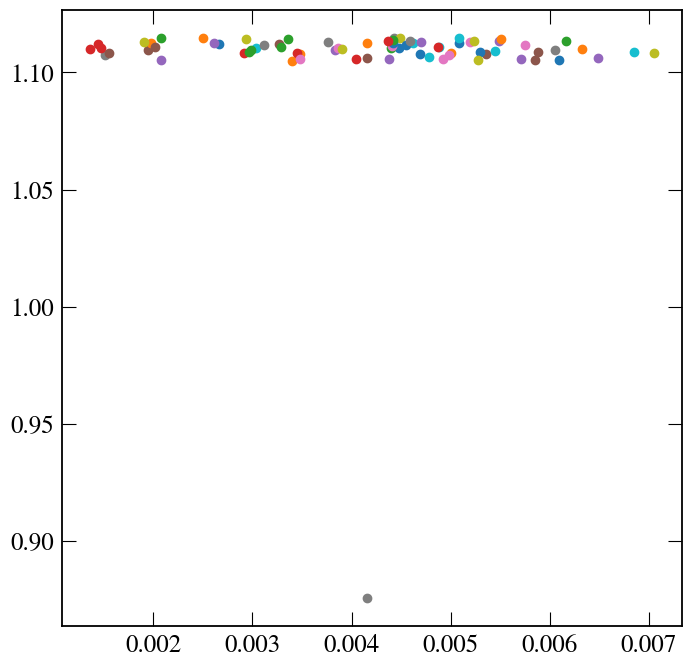

In [150]:
# create new table
tj_s5 = Table(names=ts5_unique.colnames, dtype=[col.dtype for col in ts5_unique.columns.values()])

for i in range(len(ta)):
    dsky = np.sqrt((ts5_unique['ra']-ta['RA (ICRS)'][i])**2 + (ts5_unique['dec']-ta['Dec (ICRS)'][i])**2)
    ind_ = np.argmin(dsky)
#     print(dsky[ind_], dvr[ind_])
    dvr = np.abs(ts5_unique['vel_calib'] - ta['vrad (km/s)'][i])
    
    ind_close = dsky<0.01
    if np.sum(ind_close)==1:
#         print(len(ts5_unique[ind_close]))
        tj_s5.add_row(ts5_unique[ind_close][0])
    else:
        print(i, np.sum(ind_close))
    plt.plot(dsky[ind_close], dvr[ind_close], 'o')
    

# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')

In [151]:
tj_s5

vel1,vel99,vel50,vel16,vel84,vel_std,vel_skew,vel_kurt,feh1,feh99,feh50,feh16,feh84,feh_std,feh_skew,feh_kurt,logg1,logg99,logg50,logg16,logg84,logg_std,logg_skew,logg_kurt,teff1,teff99,teff50,teff16,teff84,teff_std,teff_skew,teff_kurt,vel_calib,vel_calib_std,feh_calib_std,redchisq_1700d,chisq_1700d,absdev_1700d,ra,dec,name,field,fileinfo,utmjd,sn_1700d,moon_dist,moon_phase,moon_alt,qso_flag_wise,priority,primary,good_star_pb,good_star,ebv,gaia_source_id,parallax,parallax_error,pmra,pmdec,pmra_error,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_bp_rp_excess_factor,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,flux_w1,flux_w2,dflux_w1,dflux_w2,u_skm,g_skm,r_skm,i_skm,z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,bytes19,bytes50,float64,float64,float64,float64,float64,int64,int64,bool,float64,bool,float32,int64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32
-30.874806360646637,-27.284481134575582,-29.080389995081287,-29.85422451003307,-28.315782262850092,0.7697442184831299,0.00127073718941308,-0.02423876919953294,-2.4247412496668197,-1.8643459349490068,-2.1837329233489227,-2.2801536832680034,-2.057926857511224,0.11518007078999096,0.3969857738684475,0.509447779479363,1.542528550258805,2.647508276869494,2.084427821323648,1.8548841038647244,2.302229647914148,0.23014282399242852,0.012542893090566944,0.21973979219856643,4746.2386462004715,5113.53036870403,4918.33912297514,4857.425349690991,4995.7211173308315,74.50146375766577,0.17186829101364823,0.6511756785212901,-30.190389995081286,1.192304283309492,0.14743049061118843,1.450840202633612,2942.303930940965,0.03821108195114263,335.53156666666666,-50.355802777777775,6511703172776180864,Jhelum-field-10,data_190219/data_poly1/Jhelum_10_ccd2.fits,58369.4987472209,18.98074722290039,143.37288311139656,2.3166425228118896,-68.10531202562537,0,9,True,0.9999755298458073,True,0.017028,6511703172776180864,0.04891343152496187,0.048443798,5.7585294803710045,-5.196842791284255,0.040435158,0.044673137,16.428568,16.832685,15.849564,1.2173153,16.929927825927734,16.38309097290039,16.185470581054688,16.089839935302734,585,1524.2253,1449.4562,9.499907,29.385706,0.0,16.8008,16.4562,16.1899,16.0568,3.0223804,5.054888,10.0312,16.53168,19.900488
-25.873322893373995,-17.215450816040377,-21.558167373922387,-23.42477807387722,-19.703020402953722,1.8690439074787693,0.02973154424824697,0.0481309377295247,-2.960349628447689,-1.371566747912626,-2.2013144667002305,-2.5921438323837975,-1.804316035355808,0.3731520421642195,0.07865080939207289,-0.5355498932279601,2.930338507965835,5.9407667778471644,4.673271123478902,3.954050570434271,5.367130757768656,0.6863790906973402,-0.3357355797165693,-0.14006958283994875,4903.428681502024,5876.909558183614,5337.605185789432,5148.900937106257,5532.49776834018,201.89005865388154,0.3338447631829783,0.6022613122769154,-22.668167373922387,2.4997684584064506,0.47763461397020096,1.0878315056332972,2162.609033198995,0.07059071157463241,334.45663333333334,-50.11630277777778,6511937265674081536,Jhelum-field-10,data_190219/data_poly1/Jhelum_10_ccd2.fits,58369.4987472209,9.787140846252441,143.5469293671296,2.3166425228118896,-68.10531202562537,0,9,True,0.9999159033125854,True,0.016632,6511937265674081536,0.10124440875057444,0.088508904,5.809926501186547,-5.291250717802281,0.07839483,0.085882895,17.60738,17.978792,17.063646,1.2096692,18.05398941040039,17.573728561401367,17.401412963867188,17.32168197631836,585,453.86066,

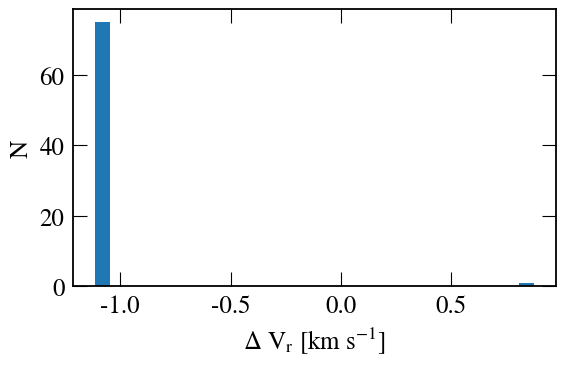

In [157]:
plt.figure(figsize=(6,4))
plt.hist(tj_s5['vel_calib'] - ta['vrad (km/s)'], bins=30);
plt.xlabel('$\Delta$ $V_r$ [km s$^{-1}$]')
plt.ylabel('N')
plt.tight_layout()

In [158]:
tj_s5.write('../data/members/input/jhelum_awad_s5.fits')

#### OC Koposov

In [157]:
toc = Table.read('../data/members/input/oc_koposov.fits')

In [160]:
toc

origin,source_id,ra,dec,fi1,fi2,rv_gsr,rv,erv,pmfi1,pmfi2,epmfi1,epmfi2,drv,dpm1,dpm2,pmra,pmdec,bp_corr,rp_corr,g_corr,cmdsel
bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,bool
S5,3888500490279502464,155.87168333333335,15.861266666666667,83.38185637615942,1.9209781846689513,121.2445939551174,219.7871593430457,1.2896948430867021,0.36040719845296343,1.2269233610245514,0.058737001474884885,0.042464280702432446,3.7238807149000053,0.0281440550839252,0.058812354320537885,-1.2784678139306027,0.02746509180760463,16.130219,14.936237,15.617935,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
APOGEE,6459095870713918336,323.376860177594,-57.460194913704576,-54.156774756786525,2.136330298250865,-191.6635109637876,-127.57266998291016,0.11691000312566757,2.386258659537896,1.2907101906334788,0.021887188706016605,0.020877611037796583,-0.050102542611483614,-0.09718854224661255,0.02168889942985408,0.25313183028370134,-2.701127072709081,15.689341,14.261924,15.040485,True
APOGEE,6459088552089593088,324.1005296688977,-57.396205276782034,-54.36663745996325,2.4708506400140644,-193.55519762144044,-129.51620483398438,0.15651699900627136,2.450724935163725,1.2905748470487866,0.024784637887625673,0.02430124991709496,-2.178886412194373,-0.021190476090612087,0.026321883727020712,0.25672336969937115,-2.757848664288604,15.92977,14.558241,15.312277,True


In [159]:
print(toc.colnames)

['origin', 'source_id', 'ra', 'dec', 'fi1', 'fi2', 'rv_gsr', 'rv', 'erv', 'pmfi1', 'pmfi2', 'epmfi1', 'epmfi2', 'drv', 'dpm1', 'dpm2', 'pmra', 'pmdec', 'bp_corr', 'rp_corr', 'g_corr', 'cmdsel']


In [574]:
print(list(toc['origin']))

['S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5', 'S5

In [572]:
np.size(np.unique(toc['source_id']))

357

In [576]:
# keep smallest rv uncertainty when duplicates available
toc.sort(['source_id', 'erv'])

In [577]:
# set up unique table
toc_unique = Table(names=toc.colnames, dtype=[col.dtype for col in toc.columns.values()])

# add first row
toc_unique.add_row(toc[0])

# add additional non-duplicate rows
for row in toc[:]:
    if row['source_id'] not in toc_unique['source_id']:
        toc_unique.add_row(row)

In [579]:
len(toc_unique), np.size(np.unique(toc_unique['source_id']))

(357, 357)

In [585]:
toc_unique.write('../data/members/input/oc_koposov_unique.fits', overwrite=True)

#### Spectre Chandra

In [189]:
tspec = Table.read('../data/members/input/spectre_chandra_trim.txt', format='ascii', delimiter='\t')

In [191]:
tspec

source_id,ra,dec,PSg,snr,Vr,Vr_err,Teff,Teff_err,logg,logg_err,feh,feh_err,afe,afe_err
int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
1491676299777912064,217.162,42.568,16.8,13.3,-139.4,0.2,5150,20,2.6,0.1,-1.51,0.05,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493316732469979136,218.035,43.452,18.7,2.4,-147.5,1.8,5520,40,3.2,0.1,-2.78,0.29,0.2,0.2
1493037765754139136,218.634,42.686,18.8,2.8,-147.2,1.1,5670,40,3.6,0.1,-1.72,0.18,0.3,0.2


#### Jet Ferguson

In [221]:
tj = Table.read('../data/members/input/jet_ferguson.fits')

In [224]:
tj

DELVE,Gaia,RAdeg,DEdeg,g0mag,r0mag,pmRA,e_pmRA,pmDE,e_pmDE,Dist,pi,e_pi
,,deg,deg,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,kpc,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10728400085912,5692169948945471872,147.32084599180075,-10.904355627308039,18.06,17.51,-0.83,0.11,-1.85,0.08,27.28,0.83,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...
10958200396025,5638741754084684416,129.44514290030060,-34.198623731342877,18.08,18.33,0.19,0.18,-1.03,0.21,30.84,0.95,0.05


#### M3 Yang

In [229]:
tm3 = Table.read('../data/members/input/m3_yang_trim.txt', format='ascii', delimiter='\t')

In [230]:
tm3

source_id,ra,dec,pmra,pmdec,Vr,Vr_err,G_0,bprp_0,feh,feh_err,Survey
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
3958917028852911232,189.1316,23.4988,-1.0765,-1.7502,-54.61,5.45,18.52,0.89,-1.59,0.08,SEGUE
...,...,...,...,...,...,...,...,...,...,...,...
1224502013678132736,236.0643,27.9842,1.85,-5.597,-182.08,16.89,17.36,0.7,-1.87,0.136,LAMOST
1223324234863007616,237.7107,26.5518,2.7691,-5.6384,-209.36,11.73,18.49,0.65,-1.357,0.073,SEGUE


### Look up source ids

In [263]:
def coord_to_source_id(c, dr=1*u.arcsec):
    """Query Gaia to get source ids for a set of ra, dec coordinates"""

    for i in range(np.size(c)):
        r = Gaia.query_object_async(coordinate=c[i], width=dr, height=dr, columns=('source_id',))
        ind_match = np.argmin(r['dist'])
        r = r[ind_match]

        if i==0:
            tg = r
        else:
            tg = vstack([tg, r])
    
    return tg

#### M2

In [549]:
tm2_trail = Table.read('../data/members/input/m2_trail.fits')
tm2_lead = Table.read('../data/members/input/m2_lead.fits')

tm2 = vstack([tm2_trail, tm2_lead])

In [550]:
tm2

Seq,RAdeg,DEdeg,Gmag,Bp-Rp,pmRA,e_pmRA,pmDE,e_pmDE,Weight
,deg,deg,mag,mag,mas / yr,mas / yr,mas / yr,mas / yr,
int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,281.2847,-16.8027,17.912,1.149,8.431,0.141,-1.340,0.116,0.62
2,282.5242,-16.0834,18.799,1.269,8.141,0.265,-1.405,0.245,0.33
...,...,...,...,...,...,...,...,...,...
123,348.7943,1.4163,19.738,0.792,1.669,0.566,-2.339,0.376,0.07
124,349.7764,0.2186,19.669,0.760,1.255,0.350,-2.795,0.305,0.19
125,349.9826,0.4109,19.531,0.812,1.475,0.436,-2.625,0.296,0.15


In [554]:
c_m2 = coord.SkyCoord(ra=tm2['RAdeg'], dec=tm2['DEdeg'], frame='icrs')

In [556]:
tg_m2 = coord_to_source_id(c_m2)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [557]:
np.size(np.unique(tg_m2['SOURCE_ID']))

125

In [558]:
tm2['source_id'] = tg_m2['SOURCE_ID']

In [559]:
tm2.write('../data/members/input/m2_grillmair_id.fits', overwrite=True)

#### M5

In [272]:
tm5 = Table.read('../data/members/input/m5_grillmair.txt', format='ascii.commented_header', delimiter='\t')

In [273]:
tm5

Rank,ra,dec,G,bp_rp,pmra,pmra_err,pmdec,pmdec_err,w
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,211.8487,10.5403,18.03,0.648,3.741,0.346,-9.117,0.096,1.0
...,...,...,...,...,...,...,...,...,...
49,213.7135,10.4678,19.555,0.746,3.806,1.591,-8.274,0.128,0.241
50,199.6213,16.5163,19.149,0.676,2.654,0.731,-7.496,0.242,0.239


In [274]:
c_m5 = coord.SkyCoord(ra=tm5['ra']*u.deg, dec=tm5['dec']*u.deg, frame='icrs')

In [275]:
tg_m5 = coord_to_source_id(c_m5)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [276]:
tm5['source_id'] = tg_m5['SOURCE_ID']

In [277]:
tm5.write('../data/members/input/m5_grillmair_id.fits', overwrite=True)

#### NGC 5824 (Triangulum)

In [287]:
tt = Table.read('../data/members/input/triangulum_yang_trim.txt', format='ascii', delimiter='\t')

In [288]:
tt

No.,ra,dec,pmra,pmra_err,pmdec,pmdec_err,Vr,Vr_err,feh,feh_err,G,GBP,GRP,Survey
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
1*,23.8285,22.8031,1.0098,0.0986,-0.1037,0.0784,-16.84,3.11,-1.913,0.068,16.759,17.222,16.106,SEGUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26 (BHB),20.7368,38.4931,1.0037,0.1538,0.2964,0.1236,-105.28,7.22,-1.378,0.04,17.908,18.044,17.637,SEGUE
27,20.1517,38.6458,0.8931,0.1369,0.2047,0.0976,-101.34,5.6,-2.036,0.041,17.676,18.13,17.124,SEGUE


In [283]:
c_tri = coord.SkyCoord(ra=tt['ra']*u.deg, dec=tt['dec']*u.deg, frame='icrs')

In [284]:
tg_tri = coord_to_source_id(c_tri)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [291]:
tt['source_id'] = tg_tri['SOURCE_ID']

In [292]:
tt

No.,ra,dec,pmra,pmra_err,pmdec,pmdec_err,Vr,Vr_err,feh,feh_err,G,GBP,GRP,Survey,source_id
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,int64
1*,23.8285,22.8031,1.0098,0.0986,-0.1037,0.0784,-16.84,3.11,-1.913,0.068,16.759,17.222,16.106,SEGUE,289325940705178112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26 (BHB),20.7368,38.4931,1.0037,0.1538,0.2964,0.1236,-105.28,7.22,-1.378,0.04,17.908,18.044,17.637,SEGUE,323455052214575104
27,20.1517,38.6458,0.8931,0.1369,0.2047,0.0976,-101.34,5.6,-2.036,0.041,17.676,18.13,17.124,SEGUE,323498551643166336


In [293]:
tt.remove_column('No.')

In [294]:
tt.write('../data/members/input/triangulum_yang_id.fits', overwrite=True)

#### GD-1

In [310]:
tgd1 = Table.read('../data/members/input/gd1_bonaca.fits')

In [311]:
tgd1

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,g,g_error,r,r_error,i,i_error,z,z_error,y,y_error,A_g,A_r,A_i,A_z,A_y,name,priority,type,field,starname,SNR,PayneID,fibID,ppPS_G,ppPS_G_Err,ppPS_R,ppPS_R_Err,ppPS_I,ppPS_I_Err,ppPS_Z,ppPS_Z_Err,ppPS_Y,ppPS_Y_Err,ppTMASS_J,ppTMASS_J_Err,ppTMASS_H,ppTMASS_H_Err,ppTMASS_K,ppTMASS_K_Err,ppWISE_W1,ppWISE_W1_Err,ppWISE_W2,ppWISE_W2_Err,ppSDSS_U,ppSDSS_U_Err,ppSDSS_G,ppSDSS_G_Err,ppSDSS_R,ppSDSS_R_Err,ppSDSS_I,ppSDSS_I_Err,ppSDSS_Z,ppSDSS_Z_Err,ppGAIA_G,ppGAIA_G_Err,Teff,uerr_Teff,lerr_Teff,std_Teff,logg,uerr_logg,lerr_logg,std_logg,FeH,uerr_FeH,lerr_FeH,std_FeH,aFe,uerr_aFe,lerr_aFe,std_aFe,Vrad,uerr_Vrad,lerr_Vrad,std_Vrad,Vrot,uerr_Vrot,lerr_Vrot,std_Vrot,Inst_R,uerr_Inst_R,lerr_Inst_R,std_Inst_R,logA,uerr_logA,lerr_logA,std_logA,Av,uerr_Av,lerr_Av,std_Av,pc_0,uerr_pc_0,lerr_pc_0,std_pc_0,pc_1,uerr_pc_1,lerr_pc_1,std_pc_1,pc_2,uerr_pc_2,lerr_pc_2,std_pc_2,pc_3,uerr_pc_3,lerr_pc_3,std_pc_3,EEP,uerr_EEP,lerr_EEP,std_EEP,logAge,uerr_logAge,lerr_logAge,std_logAge,init_FeH,uerr_init_FeH,lerr_init_FeH,std_init_FeH,init_Mass,uerr_init_Mass,lerr_init_Mass,std_init_Mass,Mass,uerr_Mass,lerr_Mass,std_Mass,logL,uerr_logL,lerr_logL,std_logL,logR,uerr_logR,lerr_logR,std_logR,Dist,uerr_Dist,lerr_Dist,std_Dist,Para,uerr_Para,lerr_Para,std_Para,lnL,lnP,lnZ,phi1,phi2,delta_Vrad,pm_phi1_cosphi2,pm_phi2,pm_phi1_cosphi2_nocorr,pm_phi2_nocorr,delta_Vrad_field,xfocal,yfocal,mem,cmdmem,pmmem,vrmem,fehmem
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,
int64,bytes28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float64,float64,float64,float64,int64,int64,bytes10,int64,bytes30,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [312]:
tgd1[tgd1['mem']]

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,g,g_error,r,r_error,i,i_error,z,z_error,y,y_error,A_g,A_r,A_i,A_z,A_y,name,priority,type,field,starname,SNR,PayneID,fibID,ppPS_G,ppPS_G_Err,ppPS_R,ppPS_R_Err,ppPS_I,ppPS_I_Err,ppPS_Z,ppPS_Z_Err,ppPS_Y,ppPS_Y_Err,ppTMASS_J,ppTMASS_J_Err,ppTMASS_H,ppTMASS_H_Err,ppTMASS_K,ppTMASS_K_Err,ppWISE_W1,ppWISE_W1_Err,ppWISE_W2,ppWISE_W2_Err,ppSDSS_U,ppSDSS_U_Err,ppSDSS_G,ppSDSS_G_Err,ppSDSS_R,ppSDSS_R_Err,ppSDSS_I,ppSDSS_I_Err,ppSDSS_Z,ppSDSS_Z_Err,ppGAIA_G,ppGAIA_G_Err,Teff,uerr_Teff,lerr_Teff,std_Teff,logg,uerr_logg,lerr_logg,std_logg,FeH,uerr_FeH,lerr_FeH,std_FeH,aFe,uerr_aFe,lerr_aFe,std_aFe,Vrad,uerr_Vrad,lerr_Vrad,std_Vrad,Vrot,uerr_Vrot,lerr_Vrot,std_Vrot,Inst_R,uerr_Inst_R,lerr_Inst_R,std_Inst_R,logA,uerr_logA,lerr_logA,std_logA,Av,uerr_Av,lerr_Av,std_Av,pc_0,uerr_pc_0,lerr_pc_0,std_pc_0,pc_1,uerr_pc_1,lerr_pc_1,std_pc_1,pc_2,uerr_pc_2,lerr_pc_2,std_pc_2,pc_3,uerr_pc_3,lerr_pc_3,std_pc_3,EEP,uerr_EEP,lerr_EEP,std_EEP,logAge,uerr_logAge,lerr_logAge,std_logAge,init_FeH,uerr_init_FeH,lerr_init_FeH,std_init_FeH,init_Mass,uerr_init_Mass,lerr_init_Mass,std_init_Mass,Mass,uerr_Mass,lerr_Mass,std_Mass,logL,uerr_logL,lerr_logL,std_logL,logR,uerr_logR,lerr_logR,std_logR,Dist,uerr_Dist,lerr_Dist,std_Dist,Para,uerr_Para,lerr_Para,std_Para,lnL,lnP,lnZ,phi1,phi2,delta_Vrad,pm_phi1_cosphi2,pm_phi2,pm_phi1_cosphi2_nocorr,pm_phi2_nocorr,delta_Vrad_field,xfocal,yfocal,mem,cmdmem,pmmem,vrmem,fehmem
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,
int64,bytes28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float64,float64,float64,float64,int64,int64,bytes10,int64,bytes30,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [320]:
th = Table.read('../data/members/input/gd1_huang.fits')

In [321]:
th

phi1,phi2,vr,err
deg,deg,km / s,km / s
float64,float64,float64,float64
-81.91989957445334,-1.9460948336806076,267.32,3.56
-70.79060516385128,-0.9902643314164534,193.88,14.46
...,...,...,...
-2.1958725584236527,-0.801400160143374,-239.38,3.85
-1.2768916399226335,-1.0867705783922863,-234.91,8.51
1.1837808889085886,-1.1733446893471462,-264.38,11.72


In [326]:
cg_huang = gc.GD1Koposov10(phi1=th['phi1'], phi2=th['phi2'])

c_huang = cg_huang.transform_to(coord.ICRS())
# for some reason, astroquery requires a SkyCoord
c_huang = coord.SkyCoord(ra=c_huang.ra, dec=c_huang.dec, frame='icrs')

In [327]:
tg_huang = coord_to_source_id(c_huang)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [328]:
th['source_id'] = tg_huang['SOURCE_ID']

In [329]:
th.write('../data/members/input/gd1_huang_id.fits', overwrite=True)

#### Sagittarius

In [33]:
tsgr = Table.read('../data/members/input/sgr_vasiliev.fits')

In [42]:
tsgr[:10]

RAdeg,DEdeg,plx,e_plx,pmRA,e_pmRA,pmDE,e_pmDE,Gmag,BPmag,Jmag,Hmag,Kmag,E(B-V),Dist,e_Dist,vLOS,e_vLOS,FeH,e_FeH,Ref,Lambda,Beta
deg,deg,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mag,mag,mag,mag,mag,mag,kpc,kpc,km / s,km / s,[-],[-],,deg,deg
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64
0.0357,-10.4442,-0.075,0.099,-1.627,0.125,-3.325,0.093,16.13,1.32,14.46,13.80,13.73,0.04,21.03,1.47,0.00,0.00,0.00,0.00,0,-72.652,-6.886
0.0628,-23.6540,0.050,0.048,-1.148,0.072,-2.844,0.053,15.04,1.40,13.26,12.62,12.48,0.02,23.63,3.93,0.00,0.00,0.00,0.00,0,-67.073,5.093
0.0737,-23.3191,0.045,0.049,-2.548,0.105,-4.186,0.058,15.55,1.25,13.98,13.38,13.28,0.02,22.73,4.04,0.00,0.00,0.00,0.00,0,-67.225,4.794
0.0851,-19.3309,0.022,0.045,-1.882,0.084,-3.660,0.049,15.56,1.47,13.75,13.05,12.92,0.02,22.82,0.58,0.00,0.00,0.00,0.00,0,-68.925,1.186
0.1081,-13.8471,0.098,0.043,-1.129,0.075,-3.148,0.046,14.97,1.50,13.13,12.38,12.27,0.04,22.35,3.30,0.00,0.00,0.00,0.00,0,-71.266,-3.774
0.1258,-32.0337,0.078,0.115,-1.815,0.185,-3.277,0.128,17.05,1.20,15.70,15.05,14.99,0.01,24.56,1.32,0.00,0.00,0.00,0.00,0,-63.489,12.690
0.1712,-11.8469,-0.007,0.063,-1.196,0.129,-2.597,0.068,15.44,1.54,13.53,12.78,12.67,0.03,21.83,2.66,0.00,0.00,0.00,0.00,0,-72.173,-5.559
0.2071,-15.3078,-0.013,0.074,-1.255,0.137,-2.879,0.088,16.33,1.26,14.71,14.06,13.99,0.03,22.11,4.36,0.00,0.00,0.00,0.00,0,-70.733,-2.411


In [35]:
# store ADQL compliant table to cross-match on the Gaia archive
tsgr.rename_column('[Fe/H]', 'FeH')
tsgr.rename_column('e_[Fe/H]', 'e_FeH')

In [36]:
tsgr.write('../data/members/input/sgr_vasiliev_adql.fits', overwrite=True)

In [37]:
tg_sgr = Table.read('../data/members/input/sgr_vasiliev_ids.gz')

In [58]:
ind_sort = np.argsort(tg_sgr['source_id'])

In [59]:
tg_sgr[ind_sort[:10]]

source_id,ra,dec,dist_arcsec
,deg,deg,
int64,float64,float64,float64
219219426355200,45.307580405564345,1.1279382416890051,0.15468358057341658
364281946252288,44.13025632626684,1.1877060240269255,0.15868056660419713
372974960167808,43.84412551445493,1.2017192077002323,0.11495430977492975
454033878448384,44.949358890591256,1.6591056888465487,0.14934272788064354
495055110557696,44.71505501298046,1.5865234675953002,0.18260939672717708
499728034941184,44.69959589563262,1.6904328831987594,0.1192972828389248
531407713914880,45.01313495548645,1.9475217155884412,0.14808396188363226
568692325424128,46.298595290209605,1.3449968543063058,0.020385440807206452


In [368]:
len(tsgr), len(tg_sgr), np.sum(tg_sgr['dist_arcsec']<0.3)

(55192, 55192, 55192)

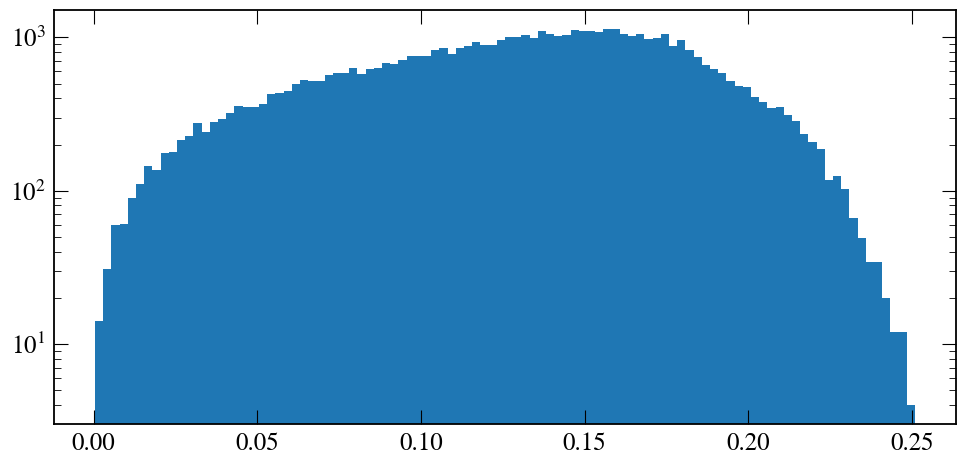

In [369]:
plt.figure(figsize=(10,5))
plt.hist(tg_sgr['dist_arcsec'], bins=100)
plt.gca().set_yscale('log')

plt.tight_layout()

### Membership origin

In [15]:
sources = ['Ibata2024', 'Li2021', 'Shipp2019', 'Awad2024', 'Koposov2023', 'Chandra2022', 'Shipp2020',
           'Ferguson2022', 'Yang2023', 'Yang2022', 'Grillmair2022', 'Grillmair2019', 'Bonaca2020', 'Huang2019',
           'Vasiliev2021']

In [16]:
member_origin = {'20.0-1':[], '300S':['Ibata2024'], 'ATLAS-Aliqa Uma':['Ibata2024','Li2021','Shipp2019'],
                 'Acheron':[], 'Alpheus':[], 'Aquarius':[], 'C-10':['Ibata2024'], 'C-11':['Ibata2024'],
                 'C-12':['Ibata2024'], 'C-13':['Ibata2024'], 'C-19':['Ibata2024'], 'C-20':['Ibata2024'],
                 'C-22':['Ibata2024'], 'C-23':['Ibata2024'], 'C-24':['Ibata2024'], 'C-25':['Ibata2024'], 'C-4':[],
                 'C-5':[], 'C-7':['Ibata2024'], 'C-8':[], 'C-9':['Ibata2024'], 'Cetus-Palca':['Li2021'],
                 'Cocytos':[], 'Corvus':[], 'Elqui':['Shipp2019'], 'Eridanus':[],
                 'GD-1':['Huang2019','Bonaca2020','Ibata2024'], 'Gaia-1':['Ibata2024'], 'Gaia-11':['Ibata2024'],
                 'Gaia-12':['Ibata2024'], 'Gaia-2':[], 'Gaia-3':[], 'Gaia-4':[], 'Gaia-5':[], 'Gaia-6':['Ibata2024'],
                 'Gaia-7':['Ibata2024'], 'Gaia-8':['Ibata2024'], 'Gaia-9':['Ibata2024'], 'Gunnthra':[], 'Hermus':[],
                 'Hrid':['Ibata2024'], 'Hydrus':['Ibata2024'], 'Hyllus':[], 'Indus':['Ibata2024', 'Shipp2019'],
                 'Jet':['Ferguson2022'], 'Jhelum':['Ibata2024','Shipp2019', 'Awad2024'], 'Kshir':['Ibata2024'],
                 'Kwando':['Ibata2024'], 'Wukong':['Ibata2024'], 'Leiptr':['Ibata2024'], 'Lethe':[],
                 'M2':['Grillmair2022', 'Ibata2024'], 'M3':['Ibata2024','Yang2023'], 'M30':['Ibata2024'],
                 'M5':['Grillmair2019','Ibata2024'], 'M68':['Ibata2024'], 'M92':['Ibata2024'], 'Molonglo':[],
                 'Murrumbidgee':[], 'NGC 1261':['Ibata2024'], 'NGC 1851':['Ibata2024'], 'NGC 2298':['Ibata2024'],
                 'NGC 2808':['Ibata2024'], 'NGC 288':['Ibata2024'], 'NGC 3201':['Ibata2024'], 'NGC 5053':[],
                 'NGC 5466':['Ibata2024'], 'NGC 5824':['Yang2022'], 'NGC 6101':['Ibata2024'], 'NGC 6362':[],
                 'NGC 6397':['Ibata2024'], 'NGC 7492':['Ibata2024'], 'New-1':['Ibata2024'], 'New-10':['Ibata2024'],
                 'New-11':['Ibata2024'], 'New-12':['Ibata2024'], 'New-13':['Ibata2024'], 'New-14':['Ibata2024'],
                 'New-15':['Ibata2024'], 'New-16':['Ibata2024'], 'New-17':['Ibata2024'], 'New-18':['Ibata2024'],
                 'New-19':['Ibata2024'], 'New-2':['Ibata2024'], 'New-20':['Ibata2024'], 'New-21':['Ibata2024'],
                 'New-22':['Ibata2024'], 'New-23':['Ibata2024'], 'New-24':['Ibata2024'], 'New-25':['Ibata2024'],
                 'New-26':['Ibata2024'], 'New-27':['Ibata2024'], 'New-3':['Ibata2024'], 'New-4':['Ibata2024'],
                 'New-5':['Ibata2024'], 'New-6':['Ibata2024'], 'New-7':['Ibata2024'], 'New-8':['Ibata2024'],
                 'New-9':['Ibata2024'], 'Omega Centauri':['Ibata2024'], 'Ophiuchus':['Ibata2024'], 'Orinoco':[],
                 'Orphan-Chenab':['Shipp2019','Ibata2024','Koposov2023'], 'PS1-A':[], 'PS1-B':[], 'PS1-C':[],
                 'PS1-D':[], 'PS1-E':[], 'Palomar 13':['Shipp2020'], 'Palomar 15':[], 'Palomar 5':['Ibata2024'],
                 'Parallel':[], 'Pegasus':[], 'Perpendicular':[], 'Phlegethon':['Ibata2024'],
                 'Phoenix':['Ibata2024','Shipp2019'], 'Ravi':[], 'SGP-S':['Ibata2024'], 'Sagittarius':['Vasiliev2021'],
                 'Sangarius':[], 'Scamander':[], 'Slidr':['Ibata2024'], 'Spectre':['Chandra2022'], 'Styx':[],
                 'Sylgr':['Ibata2024'], 'Tucana III':['Ibata2024','Shipp2019'],
                 'Turbio':[], 'Turranburra':['Shipp2019'], 'Wambelong':[], 'Willka Yaku':[], 'Ylgr':['Ibata2024']}

In [17]:
nmem = 0
for k in member_origin.keys():
    if len(member_origin[k])>0: nmem += 1
print(nmem, len(member_origin.keys()), len(names))

92 131 131


## Membership catalogs

From individual data sets get: Gaia (DR3) source_id, and optionally: Vr, Vr_err, FeH, FeH_err, aFe, aFe_err, p_mem

From Gaia DR3 get: ra, dec, pmra, pmra_error, pmdec, pmdec_error

Calculate: d_orb, X, Y, Z, V_x, V_y, V_z

### Literature input catalogs

In [20]:
def input_stream(stream, catalog):
    """Load published members of a given stream from literature tables"""
    
    # define output table
    colnames = ('source_id', 'dist', 'dist_err', 'Vr', 'Vr_err', 'FeH', 'FeH_err', 'aFe', 'aFe_err', 'p_mem')
    tout = Table(names=colnames)
    tout['source_id'] = tout['source_id'].astype(int)
    
    if catalog=='Ibata2024':
        tin = Table.read('../data/members/input/ibata_apj_labeled.fits')
        sids = dict_invibata[stream]
        
        for sid in sids:
            ind_stream = tin['name']==sid
            t_ = tin[ind_stream]
            col_empty = np.ones(len(t_)) * np.nan
                        
            # set missing velocities to nans
            ind_novel = (t_['VHel']==0) & (t_['e_VHel']==300)
            t_['VHel'][ind_novel] = np.nan
            t_['e_VHel'][ind_novel] = np.nan
            
            # construct table
            tfill = Table([t_['Gaia'], col_empty, col_empty, t_['VHel'].value, t_['e_VHel'].value,
                          col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
            tout = vstack([tout, tfill])
        
        # keep only unique rows (turns out in NGC 1261a and b there are duplicates..)
        tout = unique(tout, keys=['source_id'], keep='last')
        
    elif catalog=='Li2021':
        if stream=='Cetus-Palca':
            # RV members
            tin = Table.read('../data/members/input/palca_rv_li.csv', format='ascii.commented_header').filled(np.nan)
            col_empty = np.ones(len(tin)) * np.nan

            # construct table
            tout = Table([tin['Gaia Source ID'], col_empty, col_empty, tin['RV'], tin['RVerr'],
                          tin['FeH'], tin['FeHerr'], col_empty, col_empty, col_empty], names=colnames)
            
        elif stream=='ATLAS-Aliqa Uma':
            # RV members
            tin = Table.read('../data/members/input/aau_rv_li.csv', format='ascii.commented_header').filled(np.nan)
            col_empty = np.ones(len(tin)) * np.nan

            # construct table
            tout = Table([tin['Gaia Source ID'], col_empty, col_empty, tin['RV'], tin['RVerr'],
                          tin['FeH'], tin['FeHerr'], col_empty, col_empty, col_empty], names=colnames)
            
            # distance members
            tin = Table.read('../data/members/input/aau_dist_li.csv')
            col_empty = np.ones(len(tin)) * np.nan
            dist = 10**(0.2*tin['distance_modulus']+1) * 1e-3
            
            # sure there is a better way...
            for i in range(len(tin)):
                ind_ = tout['source_id'] == tin['source_id'][i]
                tout['dist'][ind_] = dist[i]
            
        # possibly Gaia DR2 ids?
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in tout['source_id'])
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        
        tout.sort(['source_id'])
        tout['source_id'] = qmatch['dr3_source_id']
#         tout['source_id'] = qmatch['dr3_source_id']
            

    elif catalog=='Shipp2019':
        # S5 DR1 for cross-matching radial velocities and metallicities
        ts5 = Table.read('../data/members/input/s5_unique.fits').filled(np.nan)
        ts5.rename_column('gaia_source_id', 'Gaia_Source_ID')
        
        # Shipp proper motion members
        tin = Table.read('../data/members/input/s5_shipp.txt', format='ascii.commented_header', delimiter=',')
        sids = dict_invshipp[stream]
                
        for sid in sids:
            ind_stream = tin['Stream']==sid
            # match S5 DR1
            t_ = join(tin[ind_stream], ts5, keys='Gaia_Source_ID', join_type='left')
            col_empty = np.ones(len(t_)) * np.nan
            
            # construct table
            tfill = Table([t_['Gaia_Source_ID'], col_empty, col_empty, t_['vel_calib'].value,
                           t_['vel_calib_std'].value,
                           t_['feh50'], t_['feh_calib_std'], col_empty, col_empty, t_['P_mem']], names=colnames)
            tout = vstack([tout, tfill.filled(np.nan)])
        
        # possibly Gaia DR2 ids?
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in tout['source_id'])
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        
        # keep duplicate star closer in magnitude
        qmatch.sort(['dr2_source_id', 'magnitude_difference'])
        qmatch = unique(qmatch, keys=['dr2_source_id'], keep='first')
        tout.sort(['source_id'])
        tout['source_id'] = qmatch['dr3_source_id']
    
    elif (catalog=='Awad2024') & (stream=='Jhelum'):
        tin = Table.read('../data/members/input/jhelum_awad_s5.fits').filled(np.nan)
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['gaia_source_id'], col_empty, col_empty, tin['vel_calib'].value, tin['vel_calib_std'].value,
                       tin['feh50'], tin['feh_calib_std'], col_empty, col_empty, col_empty], names=colnames)
        
#         print(np.size(np.unique(tout['source_id'])), len(tout))
#         # possibly Gaia DR2 ids?
#         # match Gaia DR2 ids to DR3
#         dr2_ids_str = ','.join(str(sid) for sid in tout['source_id'])
#         query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
#         job = Gaia.launch_job(query_dr23)
#         qmatch = job.get_results()
#         print(qmatch)
#         print(qmatch.colnames)
#         plt.hist(qmatch['dr3_source_id']-qmatch['dr2_source_id'])
#         tout['source_id'] = qmatch['dr3_source_id']
    
    elif (catalog=='Koposov2023') & (stream=='Orphan-Chenab'):
        tin = Table.read('../data/members/input/oc_koposov_unique.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['rv'], tin['erv'],
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Chandra2022') & (stream=='Spectre'):
        tin = Table.read('../data/members/input/spectre_chandra_trim.txt', format='ascii', delimiter='\t')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['Vr'], tin['Vr_err'],
                     tin['feh'], tin['feh_err'], tin['afe'], tin['afe_err'], col_empty], names=colnames)
    
    elif (catalog=='Shipp2020') & (stream=='Palomar 13'):
        # The Gaia DR2 source_ids for the RRLs are 2814894112367752192, 2814893910504601600,
        # 2811888666052959232 (cluster) and 2712246494232725120, 2815432636842520960, 2705495870795198464 (tails).

        # tail RR Lyrae
        rrl_dr2_ids = np.array([2712246494232725120, 2815432636842520960, 2705495870795198464])
        
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in rrl_dr2_ids)
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        
        # construct table
        col_empty = np.ones(len(qmatch)) * np.nan
        tout = Table([qmatch['dr3_source_id'], col_empty, col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Ferguson2022') & (stream=='Jet'):
        tin = Table.read('../data/members/input/jet_ferguson.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['Gaia'], tin['Dist'], col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Yang2023') & (stream=='M3'):
        tin = Table.read('../data/members/input/m3_yang_trim.txt', format='ascii', delimiter='\t')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['Vr'], tin['Vr_err'],
                     tin['feh'], tin['feh_err'], col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Yang2022') & (stream=='NGC 5824'):
        tin = Table.read('../data/members/input/triangulum_yang_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['Vr'], tin['Vr_err'],
                     tin['feh'], tin['feh_err'], col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Grillmair2022') & (stream=='M2'):
        tin = Table.read('../data/members/input/m2_grillmair_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, tin['Weight']], names=colnames)
    
    elif (catalog=='Grillmair2019') & (stream=='M5'):
        tin = Table.read('../data/members/input/m5_grillmair_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, col_empty, col_empty,
                     col_empty, col_empty, col_empty, col_empty, tin['w']], names=colnames)
    
    elif (catalog=='Bonaca2020') & (stream=='GD-1'):
        tin = Table.read('../data/members/input/gd1_bonaca.fits')
        tin = tin[tin['mem']]
        
        # match Gaia DR2 ids to DR3
        dr2_ids_str = ','.join(str(sid) for sid in tin['source_id'])
        query_dr23 = f"""SELECT * from gaiadr3.dr2_neighbourhood WHERE dr2_source_id IN ({dr2_ids_str})"""
        job = Gaia.launch_job(query_dr23)
        qmatch = job.get_results()
        
        # construct table
        col_empty = np.ones(len(qmatch)) * np.nan
        tout = Table([qmatch['dr3_source_id'], tin['Dist'].value, tin['std_Dist'].value, tin['Vrad'].value, 
                      tin['std_Vrad'].value,
                     tin['FeH'], tin['std_FeH'], tin['aFe'], tin['std_aFe'], col_empty], names=colnames)
    
    elif (catalog=='Huang2019') & (stream=='GD-1'):
        tin = Table.read('../data/members/input/gd1_huang_id.fits')
        col_empty = np.ones(len(tin)) * np.nan
        
        tout = Table([tin['source_id'], col_empty, col_empty, tin['vr'].value, tin['err'].value,
                     col_empty, col_empty, col_empty, col_empty, col_empty], names=colnames)
    
    elif (catalog=='Vasiliev2021') & (stream=='Sagittarius'):
        tin = Table.read('../data/members/input/sgr_vasiliev_adql.fits')
        tin_id = Table.read('../data/members/input/sgr_vasiliev_ids.gz')
        col_empty = np.ones(len(tin)) * np.nan
        
        # set missing velocities to nans
        ind_novel = (tin['vLOS']==0) & (tin['e_vLOS']==0)
        tin['vLOS'][ind_novel] = np.nan
        tin['e_vLOS'][ind_novel] = np.nan
        
        # set missing metallicities to nans
        ind_nofeh = (tin['FeH']==0) & (tin['e_FeH']==0)
        tin['FeH'][ind_nofeh] = np.nan
        tin['e_FeH'][ind_nofeh] = np.nan
        
        tout = Table([tin_id['source_id'], tin['Dist'].value, tin['e_Dist'].value, tin['vLOS'].value,
                      tin['e_vLOS'].value, tin['FeH'], tin['e_FeH'], col_empty, col_empty, col_empty], names=colnames)
    
    print(stream, catalog, len(tout), np.size(np.unique(tout['source_id'])))
    
    # sort by the source_id to allow hstacking the Gaia query
    tout.sort(['source_id'])
    
    # look up Gaia DR3 
    ids_str = ','.join(str(sid) for sid in tout['source_id'])
    query_gaia = f"""SELECT ra,
ra_error,
dec,
dec_error,
parallax,
parallax_error,
parallax_over_error,
pm,
pmra,
pmra_error,
pmdec,
pmdec_error,
ra_dec_corr,
ra_parallax_corr,
ra_pmra_corr,
ra_pmdec_corr,
dec_parallax_corr,
dec_pmra_corr,
dec_pmdec_corr,
parallax_pmra_corr,
parallax_pmdec_corr,
pmra_pmdec_corr
    FROM gaiadr3.gaia_source WHERE source_id IN ({ids_str})"""
    
#     print(query_gaia)
    
    job = Gaia.launch_job_async(query_gaia)
    qmatch = job.get_results()
    print(len(qmatch), len(tout))
#     print(qmatch)
    # remove masked columns
    qmatch_nomask = Table()
    for cname in qmatch.colnames:
        if qmatch[cname].unit==None:
            cunit = 1.
        else:
            cunit = qmatch[cname].unit
            
        qmatch_nomask[cname] = np.array(qmatch[cname]) * cunit

    tout = hstack([tout, qmatch_nomask])
          
    # set units
    tout['dist'] = tout['dist'] * u.kpc
    tout['dist_err'] = tout['dist_err'] * u.kpc
    tout['Vr'] = tout['Vr'] * u.km/u.s
    tout['Vr_err'] = tout['Vr_err'] * u.km/u.s
    
    # add stream and reference columns
    tout['name'] = [stream for x in range(len(tout))]
    tout['reference'] = [catalog for x in range(len(tout))]
    
#     print(qmatch_nomask.columns.values())
    
    return tout

In [22]:
# test
input_stream('Cetus-Palca', 'Li2021')

Cetus-Palca Li2021 25 25
INFO: Query finished. [astroquery.utils.tap.core]
25 25


source_id,dist,dist_err,Vr,Vr_err,FeH,FeH_err,aFe,aFe_err,p_mem,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,name,reference
,kpc,kpc,km / s,km / s,,,,,,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str11,str6
4953456632257474048,nan,nan,82.0,3.82,nan,nan,nan,nan,nan,39.585048682748585,0.14485621,-37.853028417716665,0.17472738,-0.1624016396636766,0.20557606,-0.7899832,1.9927014,1.4154869334411555,0.17710483,-1.4025889431015977,0.23829357,-0.31476215,0.10013474,-0.028678082,-0.036654413,-0.100313164,-0.031936698,-0.0072903093,0.03094318,-0.04253486,-0.42650193,Cetus-Palca,Li2021
4965675882934008576,nan,nan,98.55,4.73,nan,nan,nan,nan,nan,36.57352016540648,0.11386844,-36.45370058398496,0.14151631,-0.1629204253728099,0.20177379,-0.807441,1.1225096,1.02973828853325,0.14097545,-0.4468410815530785,0.20005849,-0.27242744,0.124663845,-0.025719905,-0.02369725,-0.11587729,-0.040064074,0.09098359,0.2170056,-0.20613854,-0.41901797,Cetus-Palca,Li2021
4965792362447281920,nan,nan,117.91,8.33,nan,nan,nan,nan,nan,38.11828641547462,0.08453427,-36.82991541279967,0.107384585,-0.11174758507049629,0.13985547,-0.7990219,0.9437277,0.9115503808081333,0.097550355,-0.2443314352638175,0.13069092,-0.21420231,0.1133681,-0.04029105,0.038530108,-0.04309695,0.048358142,-0.05748989,0.12270629,-0.14133391,-0.23788503,Cetus-Palca,Li2021
4965873558805479040,nan,nan,107.03,0.95,-2.08,0.14,nan,nan,nan,37.544820878089574,0.044839684,-36.380013033017214,0.06437479,-0.0048169023904748864,0.07999471,-0.060215265,0.9853076,0.8951776291851119,0.0521049,-0.41168928250575737,0.08444904,-0.2999364,0.038595058,0.106136486,-0.1771596,0.09461979,-0.16016757,0.26919046,0.12593587,-0.09651547,-0.36015064,Cetus-Palca,Li2021
4965882144443385600,nan,nan,108.27,3.48,-1.95,0.29,nan,nan,nan,37.70802161103927,0.10312039,-36.22990519160673,0.134489,0.10180545297790144,0.16683237,0.61022604,1.0807298,1.0516456578738014,0.12087052,-0.24903508832867394,0.17657359,-0.26977807,0.23502424,0.09840592,-0.04915755,-0.14920273,-0.03594075,0.091054745,0.033884805,-0.08297226,-0.29294813,Cetus-Palca,Li2021
4966098129758824064,nan,nan,100.62,6.46,nan,nan,nan,nan,nan,37.25536118518494,0.07718206,-35.71185548828448,0.10439326,0.010905634150168597,0.13480642,0.08089847,1.0650015,0.9602038498724381,0.090645134,-0.4606915508235076,0.13987347,-0.29364908,0.07189678,0.13431495,-0.19825156,0.0011389736,-0.18754728,0.20552401,0.04978561,-0.07344331,-0.38673013,Cetus-Palca,Li2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971762951104394112,nan,nan,100.23,9.01,nan,nan,nan,nan,nan,32.68621164985479,0.10131504,-31.712726053276853,0.10123889,-0.31895095128476847,0.16013971,-1.9917043,1.0662993,0.9293897518663843,0.15446557,-0.5227131545346204,0.13275233,-0.031087793,0.085754454,-0.053508405,0.03236067,-0.07574429,0.021655923,-0.18421714,0.2632507,0.0037205848,-0.100384325,Cetus-Palca,Li2021


### Create all stream tables

In [23]:
# for stream in names[:]:
for stream in ['ATLAS-Aliqa Uma', 'Cetus-Palca']:
    print(stream)
    catalogs = member_origin[stream]
    for e, catalog in enumerate(catalogs):
        t_ = input_stream(stream, catalog)
        
        if e==0:
            tout = t_
        else:
            tout = vstack([tout, t_])

        # ensure regular columns
        tout_nomask = Table()
        for cname in tout.colnames:
            if hasattr(tout[cname], 'unit') and tout[cname].unit is not None:
                tout_nomask[cname] = Column(data=np.array(tout[cname]), unit=tout[cname].unit)
            else:
                tout_nomask[cname] = Column(data=np.array(tout[cname]))

        tout_nomask.write('../data/members/streams/{:s}.fits'.format(stream), overwrite=True)

ATLAS-Aliqa Uma
ATLAS-Aliqa Uma Ibata2024 208 208
INFO: Query finished. [astroquery.utils.tap.core]
208 208
ATLAS-Aliqa Uma Li2021 96 96
INFO: Query finished. [astroquery.utils.tap.core]
96 96


ATLAS-Aliqa Uma Shipp2019 30 30
INFO: Query finished. [astroquery.utils.tap.core]
30 30
Cetus-Palca
Cetus-Palca Li2021 25 25
INFO: Query finished. [astroquery.utils.tap.core]
25 25


In [262]:
# check for duplicates
print('same catalog')
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)==1:
        tall = Table.read('../data/members/streams/{:s}.fits'.format(stream))
        ntot = len(tall)
        nunique = np.size(np.unique(tall['source_id']))
        
        if (ntot != nunique):
            print(stream, ntot, nunique, ntot-nunique, len(catalogs))
        
            unique, counts = np.unique(tall['source_id'], return_counts=True)
            duplicates = unique[counts>1]
            for i_ in duplicates:
                ind = tall['source_id']==i_
                print(tall['Vr'][ind], tall['Vr_err'][ind])

print('\ndifferent catalogs')
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)>1:
        tall = Table.read('../data/members/streams/{:s}.fits'.format(stream))
        ntot = len(tall)
        nunique = np.size(np.unique(tall['source_id']))
        
        print(stream, ntot, nunique, ntot-nunique, len(catalogs))

same catalog



different catalogs
ATLAS-Aliqa Uma 334 245 89 3
GD-1 1578 1478 100 3
Indus 1046 1032 14 2
Jhelum 1084 993 91 3
M2 140 136 4 2
M3 245 237 8 2
M5 141 128 13 2
Orphan-Chenab 1212 1037 175 3
Phoenix 71 60 11 2
Tucana III 125 106 19 2


In [24]:
# for stream in names[:]:
for stream in ['ATLAS-Aliqa Uma', 'Cetus-Palca']:
    catalogs = member_origin[stream]

    if len(catalogs)>1:
        # remove duplicates in streams based on multiple catalogs
        tall = Table.read('../data/members/streams/{:s}.fits'.format(stream)).filled(np.nan)
        tall.sort(['Vr_err', 'dist_err'])
        
        # maximum length of references
        refs = np.unique(tall['reference'])
        ref_lengths = [len(x) for x in refs]
        ref_length = sum(ref_lengths) + 2*(len(ref_lengths)-1)
        
        # set up unique table of stream members
        tall_unique = Table(names=tall.colnames, dtype=[col.dtype for col in tall.columns.values()],
                           units=[col.unit for col in tall.columns.values()])
        # set length of the reference column
        tall_unique['reference'] = tall_unique['reference'].astype(f'S{ref_length}')
        
#         # set proper column units
#         print([col.unit for col in tall.columns.values()]) 
        
        # add non-duplicate rows
        for row in tall[:]:
            if row['source_id'] not in tall_unique['source_id']:
                tall_unique.add_row(row)
            else:
                # add extra reference for the star
                ind_duplicate = tall_unique['source_id']==row['source_id']
                tall_unique['reference'][ind_duplicate] = '{:s}, {:s}'.format(tall_unique['reference'][ind_duplicate][0],
                                                                             row['reference'])
                # check if velocity exists
                if (~np.isfinite(tall_unique['Vr'][ind_duplicate]) | 
                    (row['Vr_err']<tall_unique['Vr_err'][ind_duplicate])):
                    tall_unique['Vr'][ind_duplicate] = row['Vr']
                    tall_unique['Vr_err'][ind_duplicate] = row['Vr_err']
                
                # check if distance exists
                if (~np.isfinite(tall_unique['dist'][ind_duplicate]) | 
                    (row['dist_err']<tall_unique['dist_err'][ind_duplicate])):
                    tall_unique['dist'][ind_duplicate] = row['dist']
                    tall_unique['dist_err'][ind_duplicate] = row['dist_err']
        
        print(stream, len(tall), len(tall_unique))
        
        tall_unique.write('../data/members/unique/{:s}.fits'.format(stream), overwrite=True)
    
    elif len(catalogs)==1:
        # copy over streams based on a single catalog
        tall = Table.read('../data/members/streams/{:s}.fits'.format(stream)).filled(np.nan)
        tall.write('../data/members/unique/{:s}.fits'.format(stream), overwrite=True)

ATLAS-Aliqa Uma 334 245


### Single table for all members

In [25]:
# list of streams with published members
published = []
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)>0:
        published += [stream]

In [26]:
# full catalog
for e, stream in enumerate(published):
    print(stream)
    t1 = Table.read('../data/members/streams/{:s}.fits'.format(stream))
    
    if e==0:
        tall = t1
    else:
        tall = vstack([tall, t1])

tall.write('../data/members/all_streams.fits', overwrite=True)

300S
ATLAS-Aliqa Uma
C-10
C-11
C-12
C-13
C-19
C-20
C-22
C-23
C-24
C-25
C-7
C-9
Cetus-Palca
Elqui
GD-1
Gaia-1
Gaia-11
Gaia-12
Gaia-6
Gaia-7
Gaia-8
Gaia-9
Hrid
Hydrus
Indus
Jet
Jhelum
Kshir


Kwando
Wukong
Leiptr
M2
M3
M30
M5
M68
M92
NGC 1261
NGC 1851
NGC 2298
NGC 2808
NGC 288
NGC 3201
NGC 5466
NGC 5824
NGC 6101
NGC 6397
NGC 7492
New-1
New-10
New-11
New-12
New-13
New-14
New-15
New-16
New-17
New-18
New-19
New-2
New-20
New-21
New-22
New-23
New-24
New-25
New-26
New-27
New-3
New-4
New-5
New-6
New-7
New-8
New-9
Omega Centauri
Ophiuchus
Orphan-Chenab
Palomar 13
Palomar 5
Phlegethon
Phoenix
SGP-S
Sagittarius


Slidr
Spectre
Sylgr
Tucana III
Turranburra
Ylgr


In [27]:
tall

source_id,dist,dist_err,Vr,Vr_err,FeH,FeH_err,aFe,aFe_err,p_mem,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,name,reference
,kpc,kpc,km / s,km / s,[-],[-],,,,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,bytes13
614929674862467712,--,--,--,--,--,--,--,--,--,150.33340244295138,0.2172744,13.24963486472028,0.18321106,-0.3381786908535966,0.25940955,-1.3036479,4.0808206,-2.911746254015053,0.27712572,-2.8591656877612537,0.20834441,-0.27213326,-0.2688552,-0.20517108,-0.04061675,0.122902796,-0.032932352,-0.46550173,0.36616457,-0.24776016,-0.472972,300S,Ibata2024
615585464829093376,--,--,--,--,--,--,--,--,--,151.20306019519643,0.07055353,15.0644458030475,0.07045847,0.17911830305781481,0.094154194,1.9023932,3.823125,-2.6025168420229896,0.091028675,-2.8005695571293465,0.073981054,-0.40919924,-0.3131129,-0.403757,0.27107292,0.047583494,0.17083327,-0.6234429,0.6029098,-0.3358856,-0.5342571,300S,Ibata2024
615793203807403136,--,--,289.64,13.2,--,--,--,--,--,150.80093245391498,0.105187275,15.251068516606624,0.09548935,-0.16577688810328448,0.12822632,-1.292846,3.7855484,-2.5787482483325683,0.123326175,-2.771359639657288,0.09676449,-0.19381382,-0.17572111,-0.36642805,0.04986707,0.19347896,0.035219863,-0.6044907,0.44029,-0.37176982,-0.2608366,300S,Ibata2024
616138592192425856,--,--,--,--,--,--,--,--,--,148.2127272990071,0.23687758,14.86371021955599,0.19594307,-0.33348462878182056,0.29002234,-1.1498584,3.5326731,-2.4460593020568853,0.29745242,-2.548837629445982,0.2266088,-0.29243183,-0.3753647,-0.3257198,0.14543423,0.13805312,0.18332621,-0.61194575,0.48853102,-0.24434897,-0.4707569,300S,Ibata2024
616408792882903296,--,--,299.55,13.19,--,--,--,--,--,147.8030755962404,0.06578866,15.386929543937446,0.06529123,0.06397401246297103,0.074224725,0.8618963,3.4420931,-2.1418607404594425,0.08339962,-2.6945198915518356,0.072843075,-0.34804758,-0.15600641,-0.26102147,0.25778595,0.07285713,0.22747582,-0.7075626,0.3070973,-0.27311182,-0.39333603,300S,Ibata2024
616546541071209856,--,--,297.79,5.46,--,--,--,--,--,149.20536284036064,0.0986222,15.367928462127727,0.07905106,-0.16422922891836406,0.109992206,-1.4930989,3.7338042,-2.6365814344498886,0.124232344,-2.6438103101322694,0.09245272,-0.18257877,-0.34422466,-0.35431823,-0.0060119964,0.1681687,-0.02229197,-0.5348794,0.32588485,-0.23508537,-0.3357986,300S,Ibata2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149381548457021824,--,--,--,--,--,--,--,--,--,183.42182243740444,0.13597022,-39.57385736885261,0.09558439,-0.38179508118237165,0.19138853,-1.9948691,5.0027466,-0.3860468029973564,0.14277346,-4.987829321320489,0.12189874,0.0669255,-0.31316662,-0.5687638,-0.30208716,-0.02063234,-0.22399798,-0.09994907,0.27680025,0.14315754,0.12714913,Ylgr,Ibata2024


In [28]:
# full catalog
for e, stream in enumerate(published):
    print(stream)
    t1 = Table.read('../data/members/unique/{:s}.fits'.format(stream))
    
    if e==0:
        tall_unique = t1
    else:
        tall_unique = vstack([tall_unique, t1])

tall_unique.write('../data/members/all_streams_unique.fits', overwrite=True)

300S
ATLAS-Aliqa Uma
C-10
C-11
C-12
C-13
C-19
C-20
C-22
C-23
C-24
C-25
C-7
C-9
Cetus-Palca
Elqui
GD-1
Gaia-1
Gaia-11
Gaia-12
Gaia-6
Gaia-7
Gaia-8
Gaia-9
Hrid
Hydrus
Indus
Jet
Jhelum
Kshir
Kwando
Wukong
Leiptr
M2
M3
M30
M5
M68
M92
NGC 1261
NGC 1851
NGC 2298
NGC 2808
NGC 288
NGC 3201
NGC 5466
NGC 5824
NGC 6101
NGC 6397
NGC 7492
New-1
New-10
New-11
New-12
New-13
New-14
New-15
New-16
New-17
New-18
New-19
New-2
New-20
New-21
New-22
New-23
New-24
New-25
New-26
New-27
New-3
New-4
New-5
New-6
New-7
New-8
New-9
Omega Centauri
Ophiuchus
Orphan-Chenab
Palomar 13
Palomar 5
Phlegethon
Phoenix
SGP-S
Sagittarius
Slidr
Spectre
Sylgr
Tucana III
Turranburra
Ylgr


In [29]:
tall_unique

source_id,dist,dist_err,Vr,Vr_err,FeH,FeH_err,aFe,aFe_err,p_mem,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,name,reference
,kpc,kpc,km / s,km / s,[-],[-],,,,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,bytes33
614929674862467712,--,--,--,--,--,--,--,--,--,150.33340244295138,0.2172744,13.24963486472028,0.18321106,-0.3381786908535966,0.25940955,-1.3036479,4.0808206,-2.911746254015053,0.27712572,-2.8591656877612537,0.20834441,-0.27213326,-0.2688552,-0.20517108,-0.04061675,0.122902796,-0.032932352,-0.46550173,0.36616457,-0.24776016,-0.472972,300S,Ibata2024
615585464829093376,--,--,--,--,--,--,--,--,--,151.20306019519643,0.07055353,15.0644458030475,0.07045847,0.17911830305781481,0.094154194,1.9023932,3.823125,-2.6025168420229896,0.091028675,-2.8005695571293465,0.073981054,-0.40919924,-0.3131129,-0.403757,0.27107292,0.047583494,0.17083327,-0.6234429,0.6029098,-0.3358856,-0.5342571,300S,Ibata2024
615793203807403136,--,--,289.64,13.2,--,--,--,--,--,150.80093245391498,0.105187275,15.251068516606624,0.09548935,-0.16577688810328448,0.12822632,-1.292846,3.7855484,-2.5787482483325683,0.123326175,-2.771359639657288,0.09676449,-0.19381382,-0.17572111,-0.36642805,0.04986707,0.19347896,0.035219863,-0.6044907,0.44029,-0.37176982,-0.2608366,300S,Ibata2024
616138592192425856,--,--,--,--,--,--,--,--,--,148.2127272990071,0.23687758,14.86371021955599,0.19594307,-0.33348462878182056,0.29002234,-1.1498584,3.5326731,-2.4460593020568853,0.29745242,-2.548837629445982,0.2266088,-0.29243183,-0.3753647,-0.3257198,0.14543423,0.13805312,0.18332621,-0.61194575,0.48853102,-0.24434897,-0.4707569,300S,Ibata2024
616408792882903296,--,--,299.55,13.19,--,--,--,--,--,147.8030755962404,0.06578866,15.386929543937446,0.06529123,0.06397401246297103,0.074224725,0.8618963,3.4420931,-2.1418607404594425,0.08339962,-2.6945198915518356,0.072843075,-0.34804758,-0.15600641,-0.26102147,0.25778595,0.07285713,0.22747582,-0.7075626,0.3070973,-0.27311182,-0.39333603,300S,Ibata2024
616546541071209856,--,--,297.79,5.46,--,--,--,--,--,149.20536284036064,0.0986222,15.367928462127727,0.07905106,-0.16422922891836406,0.109992206,-1.4930989,3.7338042,-2.6365814344498886,0.124232344,-2.6438103101322694,0.09245272,-0.18257877,-0.34422466,-0.35431823,-0.0060119964,0.1681687,-0.02229197,-0.5348794,0.32588485,-0.23508537,-0.3357986,300S,Ibata2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149381548457021824,--,--,--,--,--,--,--,--,--,183.42182243740444,0.13597022,-39.57385736885261,0.09558439,-0.38179508118237165,0.19138853,-1.9948691,5.0027466,-0.3860468029973564,0.14277346,-4.987829321320489,0.12189874,0.0669255,-0.31316662,-0.5687638,-0.30208716,-0.02063234,-0.22399798,-0.09994907,0.27680025,0.14315754,0.12714913,Ylgr,Ibata2024


## Figure: Sky positions of published stream members

In [115]:
print(names)

['20.0-1', '300S', 'ATLAS-Aliqa Uma', 'Acheron', 'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19', 'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8', 'C-9', 'Cetus-Palca', 'Cocytos', 'Corvus', 'Elqui', 'Eridanus', 'GD-1', 'Gaia-1', 'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5', 'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus', 'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum', 'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'Lethe', 'M2', 'M3', 'M30', 'M5', 'M68', 'M92', 'Molonglo', 'Murrumbidgee', 'NGC 1261', 'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201', 'NGC 5053', 'NGC 5466', 'NGC 5824', 'NGC 6101', 'NGC 6362', 'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12', 'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18', 'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23', 'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5', 'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri', 'Ophiuchus'

In [116]:
mwstreams.keys()

dict_keys(['20.0-1-M18', '300S-F18', 'AAU-ATLAS-L21', 'AAU-AliqaUma-L21', 'ACS-R21', 'ATLAS-I21', 'ATLAS-I24', 'Acheron-G09', 'Alpheus-G13', 'Aquarius-W11', 'C-10-I24', 'C-11-I24', 'C-12-I24', 'C-13-I24', 'C-19-I21', 'C-19-I24', 'C-20-I24', 'C-22-I24', 'C-23-I24', 'C-24-I24', 'C-25-I24', 'C-4-I21', 'C-5-I21', 'C-7-I21', 'C-7-I24', 'C-8-I21', 'C-9-I24', 'Cetus-New-Y21', 'Cetus-Palca-T21', 'Cetus-Palca-Y21', 'Cetus-Y13', 'Chenab-S19', 'Cocytos-G09', 'Corvus-M18', 'Elqui-S19', 'Eridanus-M17', 'Fimbulthul-I21', 'Fimbulthul-I24', 'Fjorm-I21', 'Fjorm-I24', 'GD-1-I21', 'GD-1-I24', 'GD-1-PB18', 'Gaia-1-I21', 'Gaia-1-I24', 'Gaia-10-I21', 'Gaia-10-I24', 'Gaia-11-I21', 'Gaia-11-I24', 'Gaia-12-I21', 'Gaia-12-I24', 'Gaia-2-I21', 'Gaia-3-M18', 'Gaia-4-M18', 'Gaia-5-M18', 'Gaia-6-I21', 'Gaia-6-I24', 'Gaia-7-I21', 'Gaia-7-I24', 'Gaia-8-I21', 'Gaia-8-I24', 'Gaia-9-I21', 'Gaia-9-I24', 'Gjoll-I21', 'Gjoll-I24', 'Gunnthra-I21', 'Hermus-G14', 'Hrid-I21', 'Hrid-I24', 'Hydrus-I24', 'Hyllus-G14', 'Indus-I24',

In [117]:
# translate stream names to galstreams
dict_invgalstreams = {'20.0-1':'20.0-1-M18', '300S':'300S-F18', 'ATLAS-Aliqa Uma':'AAU-ATLAS-L21',
                      'Acheron':'Acheron-G09', 'Alpheus':'Alpheus-G13', 'Aquarius':'Aquarius-W11', 'C-10':'C-10-I24',
                      'C-11':'C-11-I24', 'C-12':'C-12-I24', 'C-13':'C-13-I24', 'C-19':'C-19-I21', 'C-20':'C-20-I24',
                      'C-22':'C-22-I24', 'C-23':'C-23-I24', 'C-24':'C-24-I24', 'C-25':'C-25-I24', 'C-4':'C-4-I21',
                      'C-5':'C-5-I21', 'C-7':'C-7-I21', 'C-8':'C-8-I21', 'C-9':'C-9-I24',
                      'Cetus-Palca':'Cetus-Palca-T21', 'Cocytos':'Cocytos-G09', 'Corvus':'Corvus-M18',
                      'Elqui':'Elqui-S19', 'Eridanus':'Eridanus-M17', 'GD-1':'GD-1-I21', 'Gaia-1':'Gaia-1-I21',
                      'Gaia-11':'Gaia-11-I21', 'Gaia-12':'Gaia-12-I21', 'Gaia-2':'Gaia-2-I21', 'Gaia-3':'Gaia-3-M18',
                      'Gaia-4':'Gaia-4-M18', 'Gaia-5':'Gaia-5-M18', 'Gaia-6':'Gaia-6-I21', 'Gaia-7':'Gaia-7-I21',
                      'Gaia-8':'Gaia-8-I21', 'Gaia-9':'Gaia-9-I21', 'Gunnthra':'Gunnthra-I21', 'Hermus':'Hermus-G14',
                      'Hrid':'Hrid-I21', 'Hydrus':'Hydrus-I24', 'Hyllus':'Hyllus-G14', 'Indus':'Indus-S19',
                      'Jet':'Jet-F22', 'Jhelum':'Jhelum-a-B19', 'Kshir':'Kshir-I21', 'Kwando':'Kwando-I21',
                      'Wukong':'LMS1-Y20', 'Leiptr':'Leiptr-I21', 'Lethe':'Lethe-G09', 'M2':'M2-I21', 'M3':'M3-Y23',
                      'M30':'M30-S20', 'M5':'M5-G19', 'M68':'M68-P19', 'M92':'M92-I21', 'Molonglo':'Molonglo-G17',
                      'Murrumbidgee':'Murrumbidgee-G17', 'NGC 1261':'NGC1261-I21', 'NGC 1851':'NGC1851-I21',
                      'NGC 2298':'NGC2298-I21', 'NGC 2808':'NGC2808-I24', 'NGC 288':'NGC288-I21',
                      'NGC 3201':'NGC3201-P21', 'NGC 5053':'NGC5053-L06', 'NGC 5466':'NGC5466-J21',
                      'NGC 5824':'Tri-Pis-B12',
                      'NGC 6101':'NGC6101-I24', 'NGC 6362':'NGC6362-S20', 'NGC 6397':'NGC6397-I21',
                      'NGC 7492':'NGC7492-I24', 'New-1':'New-1-I24', 'New-10':'New-10-I24', 'New-11':'New-11-I24',
                      'New-12':'New-12-I24', 'New-13':'New-13-I24', 'New-14':'New-14-I24', 'New-15':'New-15-I24',
                      'New-16':'New-16-I24', 'New-17':'New-17-I24', 'New-18':'New-18-I24', 'New-19':'New-19-I24',
                      'New-2':'New-2-I24', 'New-20':'New-20-I24', 'New-21':'New-21-I24', 'New-22':'New-22-I24',
                      'New-23':'New-23-I24', 'New-24':'New-24-I24', 'New-25':'New-25-I24', 'New-26':'New-26-I24',
                      'New-27':'New-27-I24', 'New-3':'New-3-I24', 'New-4':'New-4-I24', 'New-5':'New-5-I24',
                      'New-6':'New-6-I24', 'New-7':'New-7-I24', 'New-8':'New-8-I24', 'New-9':'New-9-I24',
                      'Omega Centauri':'OmegaCen-I21', 'Ophiuchus':'Ophiuchus-C20', 'Orinoco':'Orinoco-G17',
                      'Orphan-Chenab':'Orphan-K23', 'PS1-A':'PS1-A-B16', 'PS1-B':'PS1-B-B16', 'PS1-C':'PS1-C-B16',
                      'PS1-D':'PS1-D-B16', 'PS1-E':'PS1-E-B16', 'Palomar 13':'Pal13-S20', 'Palomar 15':'Pal15-M17',
                      'Palomar 5':'Pal5-PW19', 'Parallel':'Parallel-W18', 'Pegasus':'Pegasus-P19',
                      'Perpendicular':'Perpendicular-W18', 'Phlegethon':'Phlegethon-I21', 'Phoenix':'Phoenix-S19',
                      'Ravi':'Ravi-S18', 'SGP-S':'SGP-S-Y22', 'Sagittarius':'Sagittarius-A20',
                      'Sangarius':'Sangarius-G17', 'Scamander':'Scamander-G17', 'Slidr':'Slidr-I21',
                      'Spectre':'Spectre-C22', 'Styx':'Styx-G09', 'Sylgr':'Sylgr-I21',
                      'Tucana III':'TucanaIII-S19', 'Turbio':'Turbio-S18', 'Turranburra':'Turranburra-S19',
                      'Wambelong':'Wambelong-S18', 'Willka Yaku':'Willka_Yaku-S18', 'Ylgr':'Ylgr-I21'}

In [118]:
# set up figure geometry
nstream = len(published)
ncol = 4
nrow = int(np.ceil(nstream/ncol))
print(nstream, nrow, ncol)

92 23 4


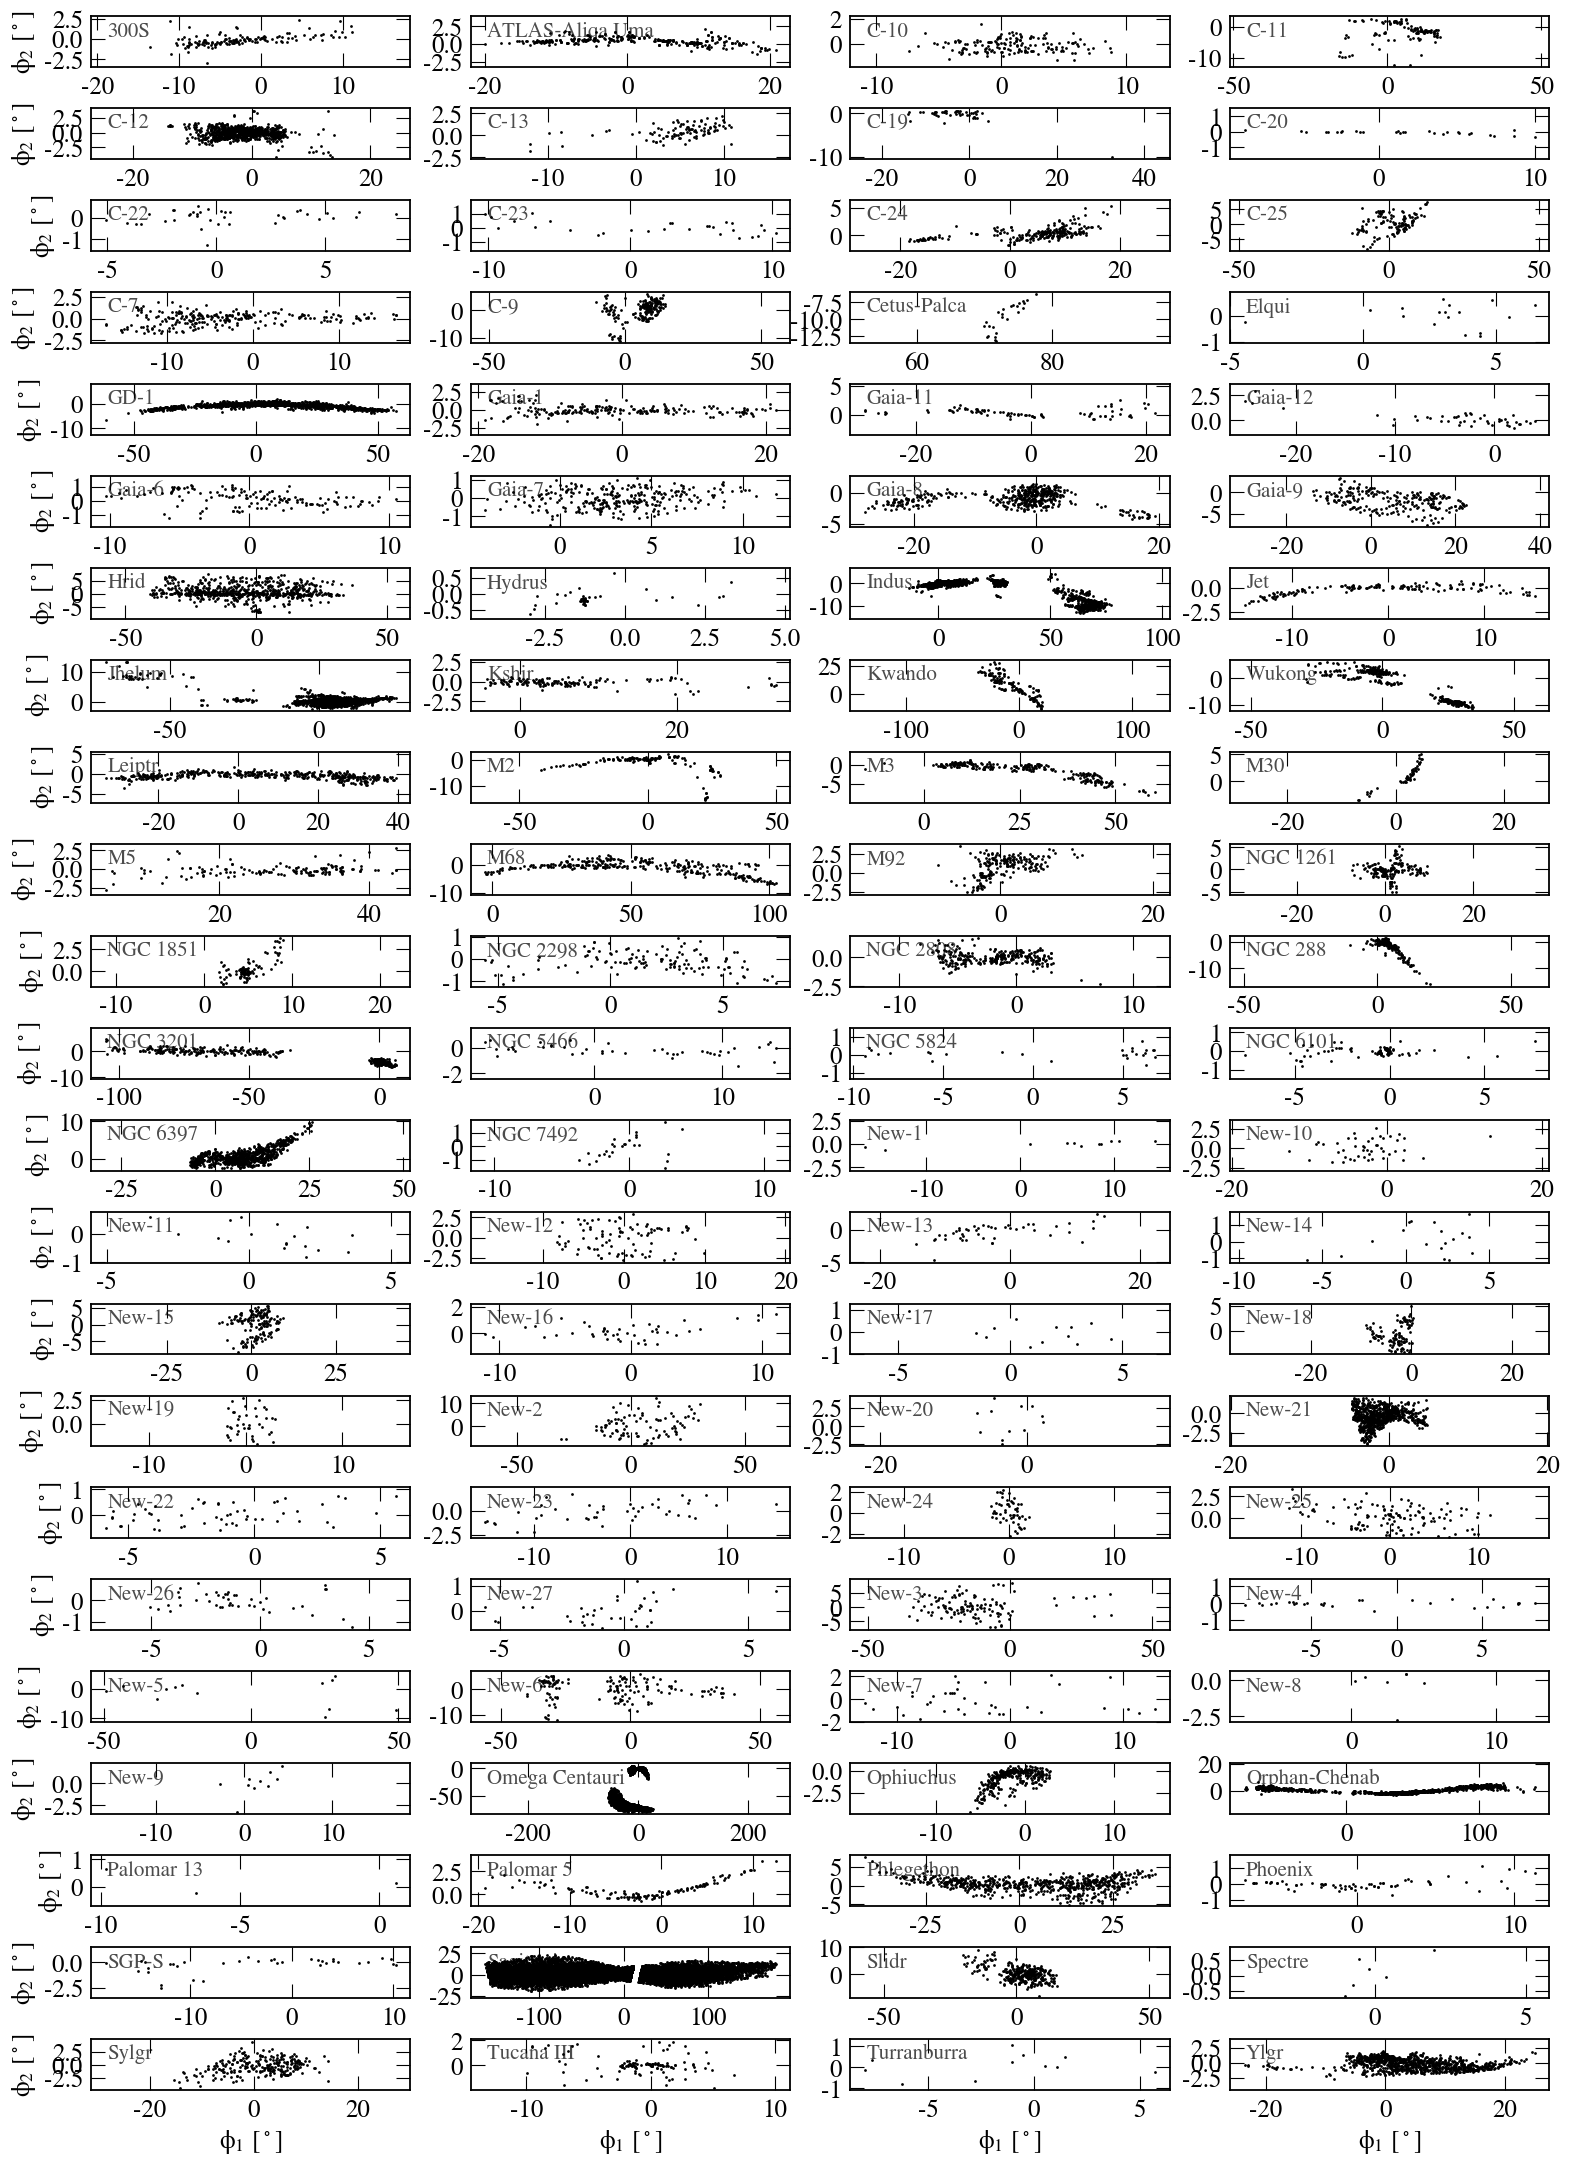

In [119]:
fig, ax = plt.subplots(nrow, ncol, figsize=(16,22))

for i in range(nstream):
    irow = i // ncol
    icol = i % ncol
    plt.sca(ax[irow][icol])
    
    ind_plot = tall['name']==published[i]
    c_ = coord.SkyCoord(ra=tall['ra'][ind_plot], dec=tall['dec'][ind_plot], frame='icrs')
    cs_ = c_.transform_to(mwstreams[dict_invgalstreams[published[i]]].stream_frame)
    
    plt.plot(cs_.phi1.wrap_at(180*u.deg), cs_.phi2, 'ko', mew=0, ms=2, rasterized=True)
#     plt.plot(tall['ra'][ind_plot], tall['dec'][ind_plot], 'ko', mew=0, ms=2, rasterized=True)
    
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.text(0.05, 0.9, published[i], transform=plt.gca().transAxes, va='top', fontsize='small', alpha=0.7)

# labels
for i in range(nrow):
    plt.sca(ax[i][0])
    plt.ylabel('$\phi_2$ [$^\circ$]')

for i in range(ncol):
    plt.sca(ax[nrow-1][i])
    plt.xlabel('$\phi_1$ [$^\circ$]')

# plt.sca(ax[nrow-1][ncol-1])
# plt.axis('off')
# plt.text(0.5, 1, '$\phi_1$ [$^\circ$]', transform=plt.gca().transAxes, va='top', ha='center')
    
plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('../plots/all_members_sky.png', dpi=300)